Insert Points AA2: [(3211.662443842477, 2182.20935973118, 0, 'AA2'), (3152.25286990665, 2265.103773221861, 0, 'AA2'), (3320.164542729657, 2241.853773221862, 0, 'AA2'), (3176.760039264772, 2241.853773221862, 0, 'AA2'), (3205.361150206349, 2241.853773221862, 0, 'AA2'), (3225.036691094754, 2241.853773221862, 0, 'AA2'), (3235.1038843189, 2241.853773221862, 0, 'AA2'), (3251.729820704118, 2241.853773221862, 0, 'AA2'), (3266.336419548743, 2241.853773221862, 0, 'AA2'), (3182.126632001957, 2255.967280494704, 90.0, 'AA3'), (3190.116161569305, 2217.785107809499, 0, 'AA2'), (3125.031846823158, 2241.84587493387, 0, 'AA2'), (3152.25286990665, 2242.659506903716, 269.3228010285361, 'AA2'), (3152.25286990665, 2255.035048829567, 269.3228010285361, 'AA2'), (3288.55776530574, 2241.853773221862, 269.3228010285361, 'AA2'), (3306.028665366385, 2241.853773221862, 269.3228010285361, 'AA2'), (3323.379726366088, 2244.947904487143, 269.3228010285361, 'AA2'), (3217.48181026558, 2285.270747496998, 269.3228010285361

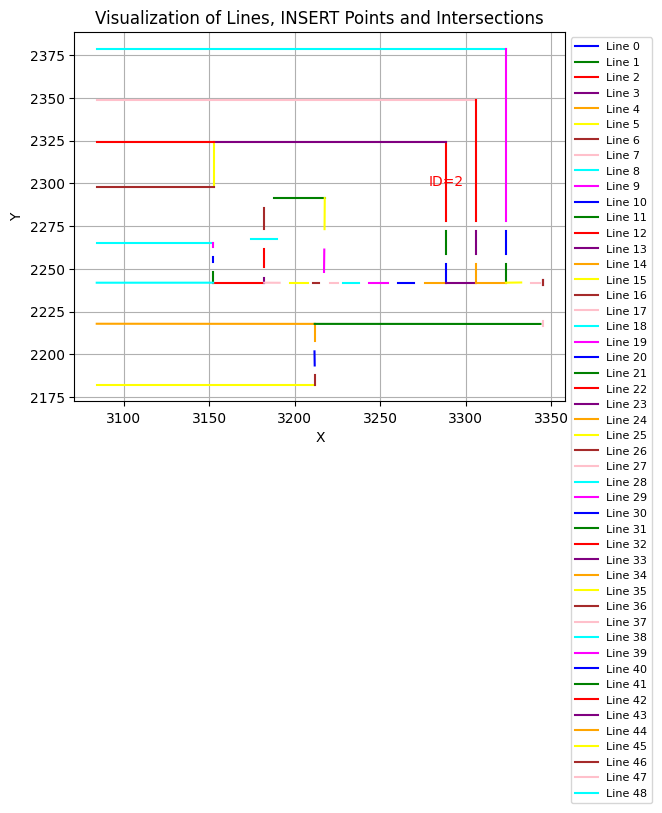

In [118]:
import ezdxf
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point, LineString
import numpy as np

class DXFVisualizer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.doc = ezdxf.readfile(file_path)
        self.msp = self.doc.modelspace()

        # 初始化数据存储
        self.lines = []
        self.insert_points_aa2 = []
        self.insert_points_other = []
        self.intersections = {}
        self.insert_point_closest_line = {}  # 存储 AA2 插入点与最接近的线段的关系

    def read_lines(self):
        """读取所有 LINE 实体并存储"""
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'brown', 'pink', 'cyan', 'magenta']  # 预定义颜色
        for idx, entity in enumerate(self.msp.query('LINE')):
            start = (entity.dxf.start.x, entity.dxf.start.y)
            end = (entity.dxf.end.x, entity.dxf.end.y)
            # 为每条线段分配不同的颜色
            color = colors[idx % len(colors)]
            self.lines.append({"id": idx, "geometry": LineString([start, end]), "color": color})
        # 处理所有的 LWPOLYLINE 实体
        last_line_id = len(self.msp.query('LINE'))  # 获取最后一个 LINE 的 ID
        # 处理所有的 LWPOLYLINE 实体
        for idx, entity in enumerate(self.msp.query('LWPOLYLINE')):
            points = [(point[0], point[1]) for point in entity.vertices()]  # 修改这里，点是元组而非对象
            # 为每个多段线的线段分配不同的颜色
            color = colors[(idx + last_line_id) % len(colors)]  # 确保颜色不会重复
            for i in range(1, len(points)):
                start = points[i - 1]
                end = points[i]
                polyline_id = last_line_id + idx  # 设置 LWPOLYLINE 的 ID 为最后一个 LINE ID + 当前索引
                self.lines.append({"id": polyline_id, "geometry": LineString([start, end]), "color": color})
        
        
        return self.lines

    def find_intersections(self):
        """查找线段之间的交点"""
        intersections = {line["id"]: [] for line in self.lines}
        for i, line1 in enumerate(self.lines):
            for j, line2 in enumerate(self.lines):
                if i >= j:
                    continue  # 避免重复计算和自交点

                if line1["geometry"].intersects(line2["geometry"]):
                    point = line1["geometry"].intersection(line2["geometry"])
                    if not point.is_empty and point.geom_type == 'Point':
                        intersections[line1["id"]].append({"line_id": line2["id"], "point": (point.x, point.y)})
                        intersections[line2["id"]].append({"line_id": line1["id"], "point": (point.x, point.y)})

        self.intersections = intersections
        return self.intersections

    def read_inserts(self):
        """读取所有 INSERT 实体的插入点，并提取旋转角度"""
        for entity in self.msp:
            if entity.dxftype() == "INSERT":
                insert_point = entity.dxf.insert
                if entity.dxf.name == "AA2" or entity.dxf.name == "AA3" :
                    # 获取旋转角度，如果不存在则设为0
                    rotation_angle = getattr(entity.dxf, 'rotation', 0)  # 如果没有旋转角度，默认设为0
                    self.insert_points_aa2.append((insert_point.x, insert_point.y, rotation_angle,entity.dxf.name))
                else:
                    rotation_angle = getattr(entity.dxf, 'rotation', 0)  # 如果没有旋转角度，默认设为0
                    self.insert_points_other.append((insert_point.x, insert_point.y, rotation_angle,entity.dxf.name))
        return self.insert_points_aa2, self.insert_points_other

    @staticmethod
    def line_angle_with_axis(start, end, axis='x'):
        """计算线段与指定轴（x轴或y轴）的夹角"""
        dx = end[0] - start[0]  # 使用索引访问元组元素
        dy = end[1] - start[1]  # 使用索引访问元组元素
        if axis == 'x':
            return math.degrees(math.atan2(dy, dx))
        elif axis == 'y':
            return math.degrees(math.atan2(dx, dy))


    def find_closest_line_for_inserts(self):
        """查找每个 AA2 插入点最接近的线段（支持多个线段）"""
        for idx, point in enumerate(self.insert_points_aa2):
            point_geom = Point(point[0], point[1])
            rotation_angle = point[2]  # 获取旋转角度
            min_distance = float('inf')  # 初始化为一个很大的值
            closest_line_ids = []  # 存储所有最接近的线段 ID
            is_point_on_line = False  # 是否在线段上
    
            # 遍历所有线段，找到距离插入点最近的线段
            for line in self.lines:
                distance = point_geom.distance(line["geometry"])
                if distance < min_distance:
                    min_distance = distance
                    closest_line_ids = [line["id"]]  # 更新最接近的线段 ID 列表
                    # 检查点是否在线段上
                    if distance == 0:
                        is_point_on_line = True
                elif distance == min_distance:
                    closest_line_ids.append(line["id"])  # 如果距离相同，添加到结果列表
    
            # 确定与插入点旋转角度接近的方向
            filtered_line_ids = self.filter_lines_by_rotation(closest_line_ids, rotation_angle)
    
            # 如果找到了符合条件的线段，使用它们
            if filtered_line_ids:
                print(f"插入点 {point} 最接近的线段（根据旋转角度和夹角筛选）: {filtered_line_ids}")
            else:
                print(f"插入点 {point} 找不到符合条件的线段")
    
            # 将筛选后的最接近的线段的 ID 和旋转角度一起记录
            self.insert_point_closest_line[idx] = {
                "line_ids": filtered_line_ids,  # 如果有多个最近的线段，存储所有的线段 ID
                "rotation_angle": rotation_angle,
                "is_point_on_line": is_point_on_line
            }
    
        return self.insert_point_closest_line

    def filter_lines_by_rotation(self, closest_line_ids, rotation_angle):
        """根据旋转角度过滤与坐标轴夹角小于10°的线段"""
        filtered_line_ids = []
        if rotation_angle % 360 < 10 or 170 < rotation_angle % 360 < 190:  # 旋转角度接近 0 或 180
            # 过滤与 x 轴夹角小于 10°的线段
            for line_id in closest_line_ids:
                line = self.lines[line_id]  # 获取线段
                angle = self.line_angle_with_axis(line["geometry"].coords[0], line["geometry"].coords[1], axis='x')
                if abs(angle) < 10 or abs(abs(angle) - 180) < 10:
                    filtered_line_ids.append(line_id)
        elif 80 < rotation_angle % 360 < 100 or 260 < rotation_angle % 360 < 280:  # 旋转角度接近 90 或 270
            # 过滤与 y 轴夹角小于 10°的线段
            for line_id in closest_line_ids:
                line = self.lines[line_id]  # 获取线段
                angle = self.line_angle_with_axis(line["geometry"].coords[0], line["geometry"].coords[1], axis='y')
                if abs(angle) < 10 or abs(abs(angle) - 180) < 10:
                    filtered_line_ids.append(line_id)

        return filtered_line_ids

    def build_line_info_dict(self):
        """通过 Insert Points AA2 Closest Line IDs with Rotation Angles 构建一个新的字典，
           键是 line_id，值是相关信息（如旋转角度、插入点信息等）
        """
        line_info_dict = {}
    
        # 遍历插入点与线段的关系
        for insert_idx, insert_info in self.insert_point_closest_line.items():
            rotation_angle = insert_info["rotation_angle"]
            is_point_on_line = insert_info["is_point_on_line"]
    
            # 遍历每个插入点关联的所有线段
            for line_id in insert_info["line_ids"]:
                if line_id not in line_info_dict:
                    line_info_dict[line_id] = {
                        "rotation_angles": [],  # 存储所有相关的旋转角度
                        "insert_points": [],    # 存储所有相关的插入点坐标
                        "is_point_on_line": is_point_on_line  # 插入点是否在线段上
                    }
    
                # 将该插入点的旋转角度添加到相应的线段信息中
                line_info_dict[line_id]["rotation_angles"].append(rotation_angle)
                line_info_dict[line_id]["insert_points"].append(self.insert_points_aa2[insert_idx])  # 使用插入点的坐标

        return line_info_dict

    def visualize(self):
        """可视化所有图形：线段、插入点和交点"""
        fig, ax = plt.subplots()

        # # 绘制线段，每条线段用不同颜色
        # for line in self.lines:
        #     x, y = line["geometry"].xy
        #     ax.plot(x, y, label=f'Line {line["id"]}', color=line["color"])
        for line in self.lines:
    # 获取线段的坐标
            x, y = line["geometry"].xy
            
            # 绘制线段
            ax.plot(x, y, label=f'Line {line["id"]}', color=line["color"])
            
            # 只在 ID 为 2 时才显示文本[7, 24, 0]
            if line["id"] == 2:
                # 计算线段的中点
                mid_x = (x[0] + x[-1]) / 2
                mid_y = (y[0] + y[-1]) / 2
                
                # 在线段中点处标注 ID
                ax.text(mid_x, mid_y, f'ID={line["id"]}', fontsize=10, ha='center', va='center', color=line["color"])
        

        # # 绘制 AA2 块插入点，并标记 ID
        # for idx, point in enumerate(self.insert_points_aa2):
        #     ax.plot(point[0], point[1], 'ro')  # 红色圆点
        #     ax.text(point[0], point[1], f"ID:{idx}", fontsize=9, color="red", verticalalignment="bottom", horizontalalignment="right")

        # # 绘制其他块的插入点，并标记 ID
        # for idx, point in enumerate(self.insert_points_other):
        #     ax.plot(point[0], point[1], 'go')  # 绿色圆点
        #     # ax.text(point[0], point[1], f"ID:{idx}", fontsize=9, color="green", verticalalignment="bottom", horizontalalignment="right")

        # # 绘制交点
        # for line_id, intersected in self.intersections.items():
        #     for entry in intersected:
        #         point = entry["point"]
        #         ax.plot(point[0], point[1], 'ko')  # 黑色圆点表示交点

        ax.set_aspect('equal')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Visualization of Lines, INSERT Points and Intersections')
    
        # 设置图例位置为最右边
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
        plt.grid(True)
        plt.show()

# 使用示例
file_path = "./dxf/Drawing1.dxf"  # 替换为你的 DXF 文件路径

# 创建对象
visualizer = DXFVisualizer(file_path)

# 获取线段数据
lines = visualizer.read_lines()
# print("Lines:", lines)

# 查找交点
intersections = visualizer.find_intersections()
# print("Intersections:", intersections)

# 获取插入点数据
insert_points_aa2, insert_points_other = visualizer.read_inserts()
print("Insert Points AA2:", insert_points_aa2)
# print("Insert Points Other:", insert_points_other)

# 查找每个 AA2 插入点最接近的直线
insert_point_closest_line = visualizer.find_closest_line_for_inserts()
print("Insert Points AA2 Closest Line IDs with Rotation Angles:", insert_point_closest_line)

# 构建线段信息字典
line_info_dict = visualizer.build_line_info_dict()

# 打印结果
print(line_info_dict)

# 可视化图形
visualizer.visualize()

###箭头 0°是左  90°是下

In [119]:
intersections

{0: [{'line_id': 14, 'point': (3288.55776530574, 2241.853773221862)},
  {'line_id': 43, 'point': (3288.55776530574, 2241.853773221862)}],
 1: [],
 2: [{'line_id': 3, 'point': (3288.55776530574, 2324.173408995739)}],
 3: [{'line_id': 2, 'point': (3288.55776530574, 2324.173408995739)},
  {'line_id': 25, 'point': (3152.895880607062, 2324.173408995739)},
  {'line_id': 42, 'point': (3152.895880607062, 2324.173408995739)}],
 4: [{'line_id': 24, 'point': (3211.662443842501, 2217.771144313088)},
  {'line_id': 41, 'point': (3211.662443842501, 2217.771144313088)}],
 5: [{'line_id': 6, 'point': (3211.662443842477, 2182.20935973118)}],
 6: [{'line_id': 5, 'point': (3211.662443842477, 2182.20935973118)}],
 7: [],
 8: [{'line_id': 9, 'point': (3152.25286990665, 2265.103773221861)}],
 9: [{'line_id': 8, 'point': (3152.25286990665, 2265.103773221861)}],
 10: [],
 11: [{'line_id': 12, 'point': (3152.25286990665, 2241.853773221862)},
  {'line_id': 38, 'point': (3152.25286990665, 2241.853773221862)}],
 1

In [120]:
# lines.pop()

In [121]:
lines

[{'id': 0,
  'geometry': <LINESTRING (3288.558 2241.854, 3288.558 2252.873)>,
  'color': 'blue'},
 {'id': 1,
  'geometry': <LINESTRING (3288.558 2258.873, 3288.558 2271.854)>,
  'color': 'green'},
 {'id': 2,
  'geometry': <LINESTRING (3288.558 2324.173, 3288.558 2277.854)>,
  'color': 'red'},
 {'id': 3,
  'geometry': <LINESTRING (3152.896 2324.173, 3288.558 2324.173)>,
  'color': 'purple'},
 {'id': 4,
  'geometry': <LINESTRING (3211.662 2217.771, 3211.662 2207.632)>,
  'color': 'orange'},
 {'id': 5,
  'geometry': <LINESTRING (3084.162 2182.209, 3211.662 2182.209)>,
  'color': 'yellow'},
 {'id': 6,
  'geometry': <LINESTRING (3211.662 2182.209, 3211.662 2187.684)>,
  'color': 'brown'},
 {'id': 7,
  'geometry': <LINESTRING (3343.662 2241.854, 3338.412 2241.854)>,
  'color': 'pink'},
 {'id': 8,
  'geometry': <LINESTRING (3084.155 2265.104, 3152.253 2265.104)>,
  'color': 'cyan'},
 {'id': 9,
  'geometry': <LINESTRING (3152.253 2265.104, 3152.253 2262.854)>,
  'color': 'magenta'},
 {'id': 10

In [122]:
insert_points_other

[(3084.162443842477, 2324.173408995739, 0, 'mis007'),
 (3084.162443842477, 2265.108642937798, 0, 'mis007'),
 (3084.162443842477, 2241.84587493387, 0, 'mis007'),
 (3084.162443842477, 2217.853773221861, 0, 'mis007'),
 (3084.162443842477, 2182.20935973118, 0, 'mis007'),
 (3152.25286990665, 2250.853773221862, 90.0, 'VALLGA'),
 (3194.126632001957, 2241.853773221862, 0, 'VALLGA'),
 (3272.969496135552, 2241.853773221862, 0, 'VALLGA'),
 (3335.412443842478, 2241.853773221862, 0, 'VALLGA'),
 (3343.662443842478, 2241.853773221862, 0, 'fsm003'),
 (3343.662443842478, 2217.853773221861, 0, 'fsm003'),
 (3209.216788028812, 2241.853773221862, 180.0, 'PIP2'),
 (3182.126632001957, 2247.853773221862, 90.0, 'VALLGA'),
 (3226.884454868328, 2241.853773221862, 180.0, 'PIP2'),
 (3240.626632001956, 2241.853773221862, 0, 'VALLGA'),
 (3084.162443842477, 2297.612086203321, 0, 'mis007'),
 (3084.162443842477, 2348.521920961534, 0, 'mis007'),
 (3084.162443842477, 2378.712275715664, 0, 'mis007'),
 (3323.499565202031, 

In [170]:
from collections import Counter
block_names = [point[3] for point in insert_points_other]
block_count = Counter(block_names)
block_count['INS07_new']

1

In [123]:
block_name = [i[-1] for i in insert_points_other] 
block_name = list(set(block_name))
block_name

['mis007', 'INS07_new', 'fsm003', '-IVC1', 'VALLGA', 'INS01B', 'VC1', 'PIP2']

In [124]:
from Entity import *
from shapely.geometry import LineString, box, Point

In [125]:
target_dxf = "./dxf/Drawing1.dxf"
for i in block_name:
    
    source_dxf = f"extracted_blocks/{i}.dxf"
    
    matching_results = find_matching_entities(source_dxf, target_dxf)
    
    # 打印找到的匹配实体数量
    print(f"Found {len(matching_results)} matching entities for block '{i}'.")

    # 遍历每个匹配结果
    for idx, result in enumerate(matching_results):
        print(f"ID: {idx}, Result: {result}")
        result['bounding_box'] = (
                (result['bounding_box'][0][0] - 1, result['bounding_box'][0][1] - 1),
                (result['bounding_box'][1][0] + 1, result['bounding_box'][1][1])
            )
                    # 从字典读取bounding_box坐标
        bounding_box = result['bounding_box']
        
        # 创建矩形框
        rect = box(bounding_box[0][0], bounding_box[0][1], bounding_box[1][0], bounding_box[1][1])
        
        # 记录相交的线段和交点
        intersected_lines = []
        
        # 遍历每一条线段
        for line_data in lines:
            line = line_data['geometry']
            # 查找交点
            intersection = line.intersection(rect)
            
            if not intersection.is_empty:
                if isinstance(intersection, Point):
                    # 交点是单个点，表示它与矩形框的某个边相交
                    position = 'on boundary'
                elif isinstance(intersection, LineString):
                    # 如果交点是线段，说明这条线段穿过矩形框
                    position = 'crossing'
                else:
                    position = 'outside'  # 其他情况认为是外部
        
                # 添加信息
                intersected_lines.append({
                    'id': line_data['id'],
                    'color': line_data['color'],
                    'intersection': intersection,
                    'position': position
                })
        
        # 如果有交点，打印相交的线段信息
        if intersected_lines:
            for intersected in intersected_lines:
                print(f"Line {intersected['id']} ({intersected['color']}):")
                print(f"  Intersection: {intersected['intersection']}")
                print(f"  Position: {intersected['position']}\n")
        else:
            # 如果没有交点，打印没有交点的信息
            print(f"No intersection found for block '{i}' (ID: {idx})\n\n")


Found 8 matching entities for block 'mis007'.
ID: 0, Result: {'type': 'block', 'name': 'mis007', 'position': (3084.162443842477, 2324.173408995739, 0.0), 'rotation': 0, 'center': (3064.662443842477, 2324.173408995739), 'bounding_box': ((3045.162443842477, 2321.173408995739), (3084.162443842477, 2327.173408995739)), 'attributes': [{'tag': '#', 'value': '15', 'position': (3046.376326460987, 2323.048408995738, 0.0), 'height': 2.25, 'rotation': 0, 'layer': '0', 'style': 'style1'}, {'tag': 'DWG.NUMBER', 'value': '2286', 'position': (3061.518877251056, 2323.048408995738, 0.0), 'height': 2.25, 'rotation': 0, 'layer': '0', 'style': 'style1'}]}
Line 42 (red):
  Intersection: LINESTRING (3084.162443842477 2324.173408995739, 3085.162443842477 2324.173408995739)
  Position: crossing

ID: 1, Result: {'type': 'block', 'name': 'mis007', 'position': (3084.162443842477, 2265.108642937798, 0.0), 'rotation': 0, 'center': (3064.662443842477, 2265.108642937798), 'bounding_box': ((3045.162443842477, 2262.10

In [126]:
from shapely.geometry import box
total_intersected_lines = []
target_dxf = "./dxf/Drawing1.dxf"
total_bounding_boxes = []
for i in block_name:
    
    source_dxf = f"extracted_blocks/{i}.dxf"
    
    matching_results = find_matching_entities(source_dxf, target_dxf)
    
    # 打印找到的匹配实体数量
    print(f"Found {len(matching_results)} matching entities for block '{i}'.")

    # 用来存储矩形框（Bounding Boxes）
    bounding_boxes = []

    # 遍历每个匹配结果
    for idx, result in enumerate(matching_results):

        result['bounding_box'] = (
            (result['bounding_box'][0][0] - 1, result['bounding_box'][0][1] - 1),
            (result['bounding_box'][1][0] + 1, result['bounding_box'][1][1] + 1)
        )
        print(f"ID: {idx}, Result: {result}")
        # 从字典读取bounding_box坐标
        bounding_box = result['bounding_box']
        
        # 创建矩形框
        rect = box(bounding_box[0][0], bounding_box[0][1], bounding_box[1][0], bounding_box[1][1])
        
        # 添加到bounding_boxes列表
        bounding_boxes.append({'id': idx, 'rect': rect})
        total_bounding_boxes.append({'id': idx, 'rect': rect,"name":i})
        # 记录相交的线段和交点
        intersected_lines = []
        
        # 遍历每一条线段
        for line_data in lines:
            line = line_data['geometry']
            # 查找交点
            intersection = line.intersection(rect)
            
            if not intersection.is_empty:
                if isinstance(intersection, Point):
                    # 交点是单个点，表示它与矩形框的某个边相交
                    position = 'on boundary'
                elif isinstance(intersection, LineString):
                    # 如果交点是线段，说明这条线段穿过矩形框
                    position = 'crossing'
                else:
                    position = 'outside'  # 其他情况认为是外部
        
                # 添加信息
                intersected_lines.append({
                    'line_id': line_data['id'],
                    'color': line_data['color'],
                    'intersection': intersection,
                    'position': position
                })
                total_intersected_lines.append({"block_id" : idx,
                    "block_name" : i ,
                    'line_id': line_data['id'],
                    'color': line_data['color'],
                    'intersection': intersection,
                    'position': position
                })
        
        # 如果有交点，打印相交的线段信息
        if intersected_lines:
            for intersected in intersected_lines:
                print(f"Line {intersected['line_id']} ({intersected['color']}):")
                print(f"  Intersection: {intersected['intersection']}")
                print(f"  Position: {intersected['position']}\n")
        else:
            # 如果没有交点，打印没有交点的信息
            print(f"No intersection found for block '{i}' (ID: {idx})\n")
   
# 用于存储相交的矩形框对
# intersecting_boxes = {}

# # 检测矩形框之间的相交
# # print(len(total_bounding_boxes))
# for i in range(len(total_bounding_boxes)):
#     for j in range(i + 1, len(total_bounding_boxes)):
#         rect1 = total_bounding_boxes[i]['rect']
#         rect2 = total_bounding_boxes[j]['rect']
        
#         # 判断两个矩形框是否相交
#         if rect1.intersects(rect2):
#             # 如果相交，保存相交信息
#             print(f"Bounding boxes {total_bounding_boxes[i]['name']},{total_bounding_boxes[i]['id']} and {total_bounding_boxes[j]['name']},{total_bounding_boxes[j]['id']} intersect.")
            
#             # 将相交的矩形框对保存到字典中
#             if (total_bounding_boxes[i]['name'], total_bounding_boxes[i]['id']) not in intersecting_boxes:
#                 intersecting_boxes[(total_bounding_boxes[i]['name'], total_bounding_boxes[i]['id'])] = []
#             if (total_bounding_boxes[j]['name'], total_bounding_boxes[j]['id']) not in intersecting_boxes:
#                 intersecting_boxes[(total_bounding_boxes[j]['name'], total_bounding_boxes[j]['id'])] = []

#             intersecting_boxes[(total_bounding_boxes[i]['name'], total_bounding_boxes[i]['id'])].append({
#                 'name': total_bounding_boxes[j]['name'],
#                 'id': total_bounding_boxes[j]['id']
#             })

#             intersecting_boxes[(total_bounding_boxes[j]['name'], total_bounding_boxes[j]['id'])].append({
#                 'name': total_bounding_boxes[i]['name'],
#                 'id': total_bounding_boxes[i]['id']
#             })
#         # else:
#         #     # 如果不相交，输出结果
#         #     # print(f"Bounding boxes {total_bounding_boxes[i]['name']},{total_bounding_boxes[i]['id']} and {total_bounding_boxes[j]['name']},{total_bounding_boxes[j]['id']} do not intersect.")

# # 打印相交的矩形框对
# print("\nIntersecting bounding boxes:")
# for key, value in intersecting_boxes.items():
#     print(f"{key}: {value}")


Found 8 matching entities for block 'mis007'.
ID: 0, Result: {'type': 'block', 'name': 'mis007', 'position': (3084.162443842477, 2324.173408995739, 0.0), 'rotation': 0, 'center': (3064.662443842477, 2324.173408995739), 'bounding_box': ((3044.162443842477, 2320.173408995739), (3085.162443842477, 2328.173408995739)), 'attributes': [{'tag': '#', 'value': '15', 'position': (3046.376326460987, 2323.048408995738, 0.0), 'height': 2.25, 'rotation': 0, 'layer': '0', 'style': 'style1'}, {'tag': 'DWG.NUMBER', 'value': '2286', 'position': (3061.518877251056, 2323.048408995738, 0.0), 'height': 2.25, 'rotation': 0, 'layer': '0', 'style': 'style1'}]}
Line 42 (red):
  Intersection: LINESTRING (3084.162443842477 2324.173408995739, 3085.162443842477 2324.173408995739)
  Position: crossing

ID: 1, Result: {'type': 'block', 'name': 'mis007', 'position': (3084.162443842477, 2265.108642937798, 0.0), 'rotation': 0, 'center': (3064.662443842477, 2265.108642937798), 'bounding_box': ((3044.162443842477, 2261.10

In [127]:
total_intersected_lines

[{'block_id': 0,
  'block_name': 'mis007',
  'line_id': 42,
  'color': 'red',
  'intersection': <LINESTRING (3084.162 2324.173, 3085.162 2324.173)>,
  'position': 'crossing'},
 {'block_id': 1,
  'block_name': 'mis007',
  'line_id': 8,
  'color': 'cyan',
  'intersection': <LINESTRING (3084.155 2265.104, 3085.162 2265.104)>,
  'position': 'crossing'},
 {'block_id': 2,
  'block_name': 'mis007',
  'line_id': 38,
  'color': 'cyan',
  'intersection': <LINESTRING (3084.162 2241.846, 3085.162 2241.846)>,
  'position': 'crossing'},
 {'block_id': 3,
  'block_name': 'mis007',
  'line_id': 24,
  'color': 'orange',
  'intersection': <LINESTRING (3085.162 2217.853, 3084.162 2217.854)>,
  'position': 'crossing'},
 {'block_id': 4,
  'block_name': 'mis007',
  'line_id': 5,
  'color': 'yellow',
  'intersection': <LINESTRING (3084.162 2182.209, 3085.162 2182.209)>,
  'position': 'crossing'},
 {'block_id': 5,
  'block_name': 'mis007',
  'line_id': 26,
  'color': 'brown',
  'intersection': <LINESTRING (308

In [128]:
lines

[{'id': 0,
  'geometry': <LINESTRING (3288.558 2241.854, 3288.558 2252.873)>,
  'color': 'blue'},
 {'id': 1,
  'geometry': <LINESTRING (3288.558 2258.873, 3288.558 2271.854)>,
  'color': 'green'},
 {'id': 2,
  'geometry': <LINESTRING (3288.558 2324.173, 3288.558 2277.854)>,
  'color': 'red'},
 {'id': 3,
  'geometry': <LINESTRING (3152.896 2324.173, 3288.558 2324.173)>,
  'color': 'purple'},
 {'id': 4,
  'geometry': <LINESTRING (3211.662 2217.771, 3211.662 2207.632)>,
  'color': 'orange'},
 {'id': 5,
  'geometry': <LINESTRING (3084.162 2182.209, 3211.662 2182.209)>,
  'color': 'yellow'},
 {'id': 6,
  'geometry': <LINESTRING (3211.662 2182.209, 3211.662 2187.684)>,
  'color': 'brown'},
 {'id': 7,
  'geometry': <LINESTRING (3343.662 2241.854, 3338.412 2241.854)>,
  'color': 'pink'},
 {'id': 8,
  'geometry': <LINESTRING (3084.155 2265.104, 3152.253 2265.104)>,
  'color': 'cyan'},
 {'id': 9,
  'geometry': <LINESTRING (3152.253 2265.104, 3152.253 2262.854)>,
  'color': 'magenta'},
 {'id': 10

Found 8 matching entities for block 'mis007'.
ID: 0, Result: {'type': 'block', 'name': 'mis007', 'position': (3084.162443842477, 2324.173408995739, 0.0), 'rotation': 0, 'center': (3064.662443842477, 2324.173408995739), 'bounding_box': ((3045.162443842477, 2321.173408995739), (3084.162443842477, 2327.173408995739)), 'attributes': [{'tag': '#', 'value': '15', 'position': (3046.376326460987, 2323.048408995738, 0.0), 'height': 2.25, 'rotation': 0, 'layer': '0', 'style': 'style1'}, {'tag': 'DWG.NUMBER', 'value': '2286', 'position': (3061.518877251056, 2323.048408995738, 0.0), 'height': 2.25, 'rotation': 0, 'layer': '0', 'style': 'style1'}]}
ID: 1, Result: {'type': 'block', 'name': 'mis007', 'position': (3084.162443842477, 2265.108642937798, 0.0), 'rotation': 0, 'center': (3064.662443842477, 2265.108642937798), 'bounding_box': ((3045.162443842477, 2262.108642937798), (3084.162443842477, 2268.108642937798)), 'attributes': [{'tag': '#', 'value': '18', 'position': (3046.376326460987, 2263.98364

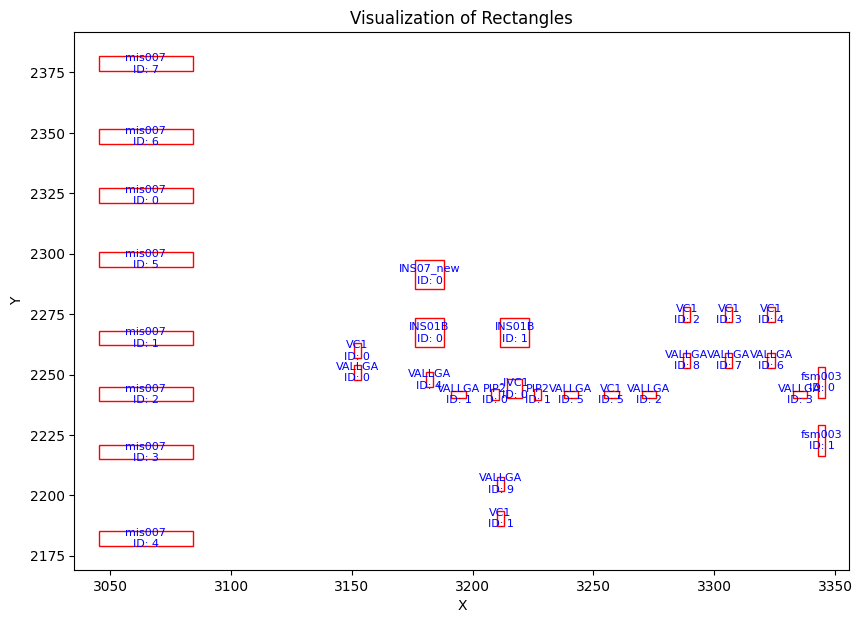

In [129]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 保存矩形框的信息
rectangles_info = []

# 遍历每个块的名称
for i in block_name:
    source_dxf = f"extracted_blocks/{i}.dxf"
    matching_results = find_matching_entities(source_dxf, target_dxf)
    
    print(f"Found {len(matching_results)} matching entities for block '{i}'.")

    # 遍历每个匹配结果并记录矩形框信息
    for idx, result in enumerate(matching_results):
        print(f"ID: {idx}, Result: {result}")
        
        # 从字典读取bounding_box坐标
        bounding_box = result['bounding_box']
        
        if len(bounding_box) != 2 or len(bounding_box[0]) != 2 or len(bounding_box[1]) != 2:
            print(f"Skipping invalid bounding box: {bounding_box}")
            continue  # 跳过无效的bounding_box
        
        # 从两个点计算 x_min, y_min, x_max, y_max
        (x_min, y_min), (x_max, y_max) = bounding_box
        
        # 创建矩形框并保存信息
        rect_info = {
            'id': idx,
            'name': i,
            'bounding_box': (x_min, y_min, x_max, y_max)
        }
        rectangles_info.append(rect_info)

# 输出记录的矩形框信息
for rect in rectangles_info:
    print(f"Block: {rect['name']}, ID: {rect['id']}, Bounding Box: {rect['bounding_box']}\n")

# 可视化所有矩形框
def visualize_rectangles(rectangles):
    fig, ax = plt.subplots(figsize=(10, 10))

    all_x = []
    all_y = []
    
    for rect in rectangles:
        bbox = rect['bounding_box']
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        
        # 绘制矩形框
        rect_patch = patches.Rectangle(
            (x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect_patch)

        # 在矩形框中心显示块名称和ID
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        ax.text(center_x, center_y, f"{rect['name']}\nID: {rect['id']}",
                fontsize=8, color='blue', ha='center', va='center')

        # 保存坐标用于调整显示范围
        all_x.extend([x_min, x_max])
        all_y.extend([y_min, y_max])

    # 设置图像显示范围，避免范围过大
    if all_x and all_y:
        ax.set_xlim(min(all_x) - 10, max(all_x) + 10)
        ax.set_ylim(min(all_y) - 10, max(all_y) + 10)
    else:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
    ax.set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Visualization of Rectangles')
    plt.show()

# 调用可视化函数
visualize_rectangles(rectangles_info)


In [130]:
rectangles_info

[{'id': 0,
  'name': 'mis007',
  'bounding_box': (3045.162443842477,
   2321.173408995739,
   3084.162443842477,
   2327.173408995739)},
 {'id': 1,
  'name': 'mis007',
  'bounding_box': (3045.162443842477,
   2262.108642937798,
   3084.162443842477,
   2268.108642937798)},
 {'id': 2,
  'name': 'mis007',
  'bounding_box': (3045.162443842477,
   2238.84587493387,
   3084.162443842477,
   2244.84587493387)},
 {'id': 3,
  'name': 'mis007',
  'bounding_box': (3045.162443842477,
   2214.853773221861,
   3084.162443842477,
   2220.853773221861)},
 {'id': 4,
  'name': 'mis007',
  'bounding_box': (3045.162443842477,
   2179.20935973118,
   3084.162443842477,
   2185.20935973118)},
 {'id': 5,
  'name': 'mis007',
  'bounding_box': (3045.162443842477,
   2294.612086203321,
   3084.162443842477,
   2300.612086203321)},
 {'id': 6,
  'name': 'mis007',
  'bounding_box': (3045.162443842477,
   2345.521920961534,
   3084.162443842477,
   2351.521920961534)},
 {'id': 7,
  'name': 'mis007',
  'bounding_bo

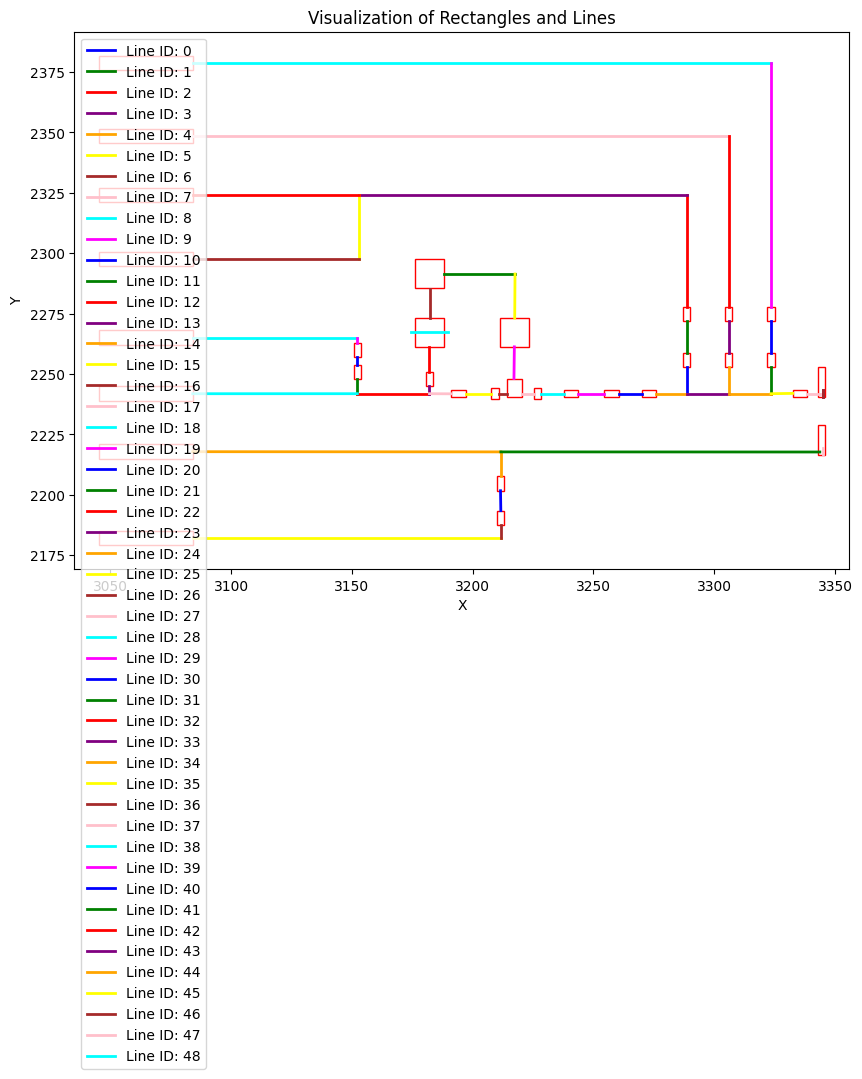

In [131]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import LineString

# 假设你已经有了包含线段的列表 Lines
Lines = lines

# 可视化矩形框和线段
def visualize_rectangles_and_lines(rectangles, lines):
    fig, ax = plt.subplots(figsize=(10, 10))

    all_x = []
    all_y = []

    # 绘制矩形框
    for rect in rectangles:
        bbox = rect['bounding_box']
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min

        # 绘制矩形框
        rect_patch = patches.Rectangle(
            (x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect_patch)

        # 在矩形框中心显示块名称和ID
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        # ax.text(center_x, center_y, f"{rect['name']}\nID: {rect['id']}",
        #         fontsize=8, color='blue', ha='center', va='center')

        # 保存坐标用于调整显示范围
        all_x.extend([x_min, x_max])
        all_y.extend([y_min, y_max])

    # 绘制线段
    for line in lines:
        # 提取线段坐标
        x, y = line['geometry'].xy
        color = line['color']
        
        # 绘制线段
        ax.plot(x, y, color=color, linewidth=2, label=f"Line ID: {line['id']}")
        # ax.plot(x, y, color='black', linewidth=2)
        # 保存坐标用于调整显示范围
        all_x.extend(x)
        all_y.extend(y)

    # 设置图像显示范围，避免范围过大
    if all_x and all_y:
        ax.set_xlim(min(all_x) - 10, max(all_x) + 10)
        ax.set_ylim(min(all_y) - 10, max(all_y) + 10)
    else:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
    ax.set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Visualization of Rectangles and Lines')

    # 显示图例
    ax.legend()
    plt.show()

# 调用可视化函数
visualize_rectangles_and_lines(rectangles_info, Lines)


In [132]:
line_info_dict

{5: {'rotation_angles': [0],
  'insert_points': [(3211.662443842477, 2182.20935973118, 0, 'AA2')],
  'is_point_on_line': True},
 8: {'rotation_angles': [0],
  'insert_points': [(3152.25286990665, 2265.103773221861, 0, 'AA2')],
  'is_point_on_line': True},
 44: {'rotation_angles': [0],
  'insert_points': [(3320.164542729657, 2241.853773221862, 0, 'AA2')],
  'is_point_on_line': True},
 12: {'rotation_angles': [0],
  'insert_points': [(3176.760039264772, 2241.853773221862, 0, 'AA2')],
  'is_point_on_line': True},
 15: {'rotation_angles': [0],
  'insert_points': [(3205.361150206349, 2241.853773221862, 0, 'AA2')],
  'is_point_on_line': True},
 17: {'rotation_angles': [0],
  'insert_points': [(3225.036691094754, 2241.853773221862, 0, 'AA2')],
  'is_point_on_line': True},
 18: {'rotation_angles': [0],
  'insert_points': [(3235.1038843189, 2241.853773221862, 0, 'AA2')],
  'is_point_on_line': True},
 19: {'rotation_angles': [0],
  'insert_points': [(3251.729820704118, 2241.853773221862, 0, 'AA2

In [133]:
intersections

{0: [{'line_id': 14, 'point': (3288.55776530574, 2241.853773221862)},
  {'line_id': 43, 'point': (3288.55776530574, 2241.853773221862)}],
 1: [],
 2: [{'line_id': 3, 'point': (3288.55776530574, 2324.173408995739)}],
 3: [{'line_id': 2, 'point': (3288.55776530574, 2324.173408995739)},
  {'line_id': 25, 'point': (3152.895880607062, 2324.173408995739)},
  {'line_id': 42, 'point': (3152.895880607062, 2324.173408995739)}],
 4: [{'line_id': 24, 'point': (3211.662443842501, 2217.771144313088)},
  {'line_id': 41, 'point': (3211.662443842501, 2217.771144313088)}],
 5: [{'line_id': 6, 'point': (3211.662443842477, 2182.20935973118)}],
 6: [{'line_id': 5, 'point': (3211.662443842477, 2182.20935973118)}],
 7: [],
 8: [{'line_id': 9, 'point': (3152.25286990665, 2265.103773221861)}],
 9: [{'line_id': 8, 'point': (3152.25286990665, 2265.103773221861)}],
 10: [],
 11: [{'line_id': 12, 'point': (3152.25286990665, 2241.853773221862)},
  {'line_id': 38, 'point': (3152.25286990665, 2241.853773221862)}],
 1

In [134]:
total_intersected_lines

[{'block_id': 0,
  'block_name': 'mis007',
  'line_id': 42,
  'color': 'red',
  'intersection': <LINESTRING (3084.162 2324.173, 3085.162 2324.173)>,
  'position': 'crossing'},
 {'block_id': 1,
  'block_name': 'mis007',
  'line_id': 8,
  'color': 'cyan',
  'intersection': <LINESTRING (3084.155 2265.104, 3085.162 2265.104)>,
  'position': 'crossing'},
 {'block_id': 2,
  'block_name': 'mis007',
  'line_id': 38,
  'color': 'cyan',
  'intersection': <LINESTRING (3084.162 2241.846, 3085.162 2241.846)>,
  'position': 'crossing'},
 {'block_id': 3,
  'block_name': 'mis007',
  'line_id': 24,
  'color': 'orange',
  'intersection': <LINESTRING (3085.162 2217.853, 3084.162 2217.854)>,
  'position': 'crossing'},
 {'block_id': 4,
  'block_name': 'mis007',
  'line_id': 5,
  'color': 'yellow',
  'intersection': <LINESTRING (3084.162 2182.209, 3085.162 2182.209)>,
  'position': 'crossing'},
 {'block_id': 5,
  'block_name': 'mis007',
  'line_id': 26,
  'color': 'brown',
  'intersection': <LINESTRING (308

In [135]:
insert_point_closest_line
###箭头 0°是左  90°是下

{0: {'line_ids': [5], 'rotation_angle': 0, 'is_point_on_line': True},
 1: {'line_ids': [8], 'rotation_angle': 0, 'is_point_on_line': True},
 2: {'line_ids': [44], 'rotation_angle': 0, 'is_point_on_line': True},
 3: {'line_ids': [12], 'rotation_angle': 0, 'is_point_on_line': True},
 4: {'line_ids': [15], 'rotation_angle': 0, 'is_point_on_line': True},
 5: {'line_ids': [17], 'rotation_angle': 0, 'is_point_on_line': True},
 6: {'line_ids': [18], 'rotation_angle': 0, 'is_point_on_line': True},
 7: {'line_ids': [19], 'rotation_angle': 0, 'is_point_on_line': True},
 8: {'line_ids': [20], 'rotation_angle': 0, 'is_point_on_line': True},
 9: {'line_ids': [22], 'rotation_angle': 90.0, 'is_point_on_line': True},
 10: {'line_ids': [24], 'rotation_angle': 0, 'is_point_on_line': False},
 11: {'line_ids': [38], 'rotation_angle': 0, 'is_point_on_line': False},
 12: {'line_ids': [11],
  'rotation_angle': 269.3228010285361,
  'is_point_on_line': True},
 13: {'line_ids': [10],
  'rotation_angle': 269.322

In [136]:
import copy

In [137]:
def find_connected_block_by_line(line_id, visited_lines=None, start_block_name=None, start_block_id=None, block_paths=None):
    if visited_lines is None:
        visited_lines = set()  # 使用 set 来避免重复访问
    if block_paths is None:
        block_paths = {}  # 用于存储块和路径的映射
    visited_lines = set()
    # 使用栈来模拟递归
    stack = [(line_id, [], visited_lines)]  # stack 存储 (当前line_id, 当前路径, 已访问的线段)
    print(stack)
    while stack:
        current_line_id, path, visited_lines = stack.pop()
        # print("c:",current_line_id, "p:",path, "v:",visited_lines)
        path = path + [current_line_id]  # 更新当前路径

        # 如果该 line_id 已经访问过，跳过
        if current_line_id in visited_lines:
            continue

        # 标记当前 line_id 为已访问
        visited_lines.add(current_line_id)

        # 查找与当前 line_id 相关联的块
        connected_block = find_block_by_line_id(current_line_id)
        print("connected_block:",connected_block)
        print("start_block_name:",start_block_name)
        # 如果找到了一个连接的块，并且它不是起始块
        if connected_block:
            for b in connected_block:
                if connected_block and (b[0] != start_block_name or b[1] != start_block_id):
                    if b not in block_paths:
                        block_paths[b] = []  # 初始化该块的路径列表
                    block_paths[b].append(path)  # 记录路径
                    continue  # 找到目标块，跳过继续递归

        # 查找与当前 line_id 相交的所有线段
        intersecting_lines = intersections.get(current_line_id, [])
        print("intersecting_lines",intersecting_lines)

        # 将所有与当前线段相交的线段压入栈中
        for intersection in intersecting_lines:
            intersected_line_id = intersection['line_id']
            if intersected_line_id not in visited_lines:
                stack.append((intersected_line_id, path, visited_lines.copy()))  # 使用路径副本，避免影响其他路径

    # 返回最终的块路径和已访问的线段
    return block_paths, visited_lines


def find_block_by_line_id(line_id):
    blocks = []  # 用于存储所有匹配的块信息
    for item in total_intersected_lines:
        if item['line_id'] == line_id:
            blocks.append((item['block_name'], item['block_id']))  # 将匹配的块添加到列表
    return blocks if blocks else None  # 如果找到匹配项，返回所有匹配的块；否则返回 None



# 查找给定 block_name 和 block_id 的所有相关线段
def find_line_ids_by_block(block_name, block_id):
    line_ids = []
    for item in total_intersected_lines:
        if item['block_name'] == block_name and item['block_id'] == block_id:
            line_ids.append(item['line_id'])
    return line_ids


def insert_before(a, target, value):
    # 查找目标值的位置
    index = a.index(target)
    # 插入新值，目标值的前面是目标值位置的索引
    a.insert(index, value)

def insert_after(a, target, value):
    # 查找目标值的位置
    index = a.index(target)
    # 插入新值，目标值位置后面是目标值位置+1
    a.insert(index + 1, value)

def check_order(a, b):
    # 假设 b 中包含 a 中的两个数字
    if len(b) != 2:
        return "error"  # 如果 b 不是两个数字，返回错误

    # 查找 a 中两个数字的索引
    first_index = a.index(b[0])
    second_index = a.index(b[1])

    # 判断两个数字是否相邻
    if abs(first_index - second_index) == 1:
        if first_index < second_index:
            return 1  # first_index 在 second_index 前
        else:
            return 0  # first_index 在 second_index 后
    else:
        return "error"  # 如果两个数字不相邻，则返回无法判断


def remove_key_by_value(d, value_to_remove):
    # 创建一个列表存储要删除的键
    keys_to_delete = [key for key, value in d.items() if value == value_to_remove]
    
    # 删除匹配的键
    for key in keys_to_delete:
        del d[key]
    
    return d

def get_rotation_for_line_ids(line_ids, insert_point_closest_line):
    rotations = {}
    # 遍历 insert_point_closest_line 中的所有记录
    for key, value in insert_point_closest_line.items():
        # 遍历每个 line_ids 列表中的元素
        for id in value['line_ids']:
            if id in line_ids:
                rotations[id] = value['rotation_angle']
    return rotations

def check_dicts_in_list(dict_list):
    if all(d == dict_list[0] for d in dict_list):
        return dict_list[0]
    else:
        return "error"

def get_line_info_by_id(lines, line_id):
    """
    根据线的id从lines中提取对应的信息
    :param lines: 包含线信息的列表
    :param line_id: 要提取的线id
    :return: 提取的线信息，或None
    """
    for line in lines:
        if line['id'] == line_id:
            geometry = line['geometry']
            # 如果geometry是LineString对象，可以直接获取坐标
            if isinstance(geometry, LineString):
                return {
                    'geometry': geometry,
                    'color': line['color']
                }
            else:
                # 如果geometry是字符串，需要转换为LineString对象
                geometry_coords = parse_geometry(geometry)
                return {
                    'geometry': LineString(geometry_coords),
                    'color': line['color']
                }
    return None


def determine_direction(lines, id1, id2, arrow_direction, arrow_on_line_id):
    """
    判断两条线的指向关系，考虑箭头在哪条线上
    :param lines: 包含线信息的列表
    :param id1: 第一条线的id
    :param id2: 第二条线的id
    :param arrow_direction: 箭头方向 ("left", "right", "up", "bottom")
    :param arrow_on_line_id: 箭头在哪条线上（"id1" 或 "id2"）
    :return: 指向关系数据结构，便于后续处理
    """
    line1_info = get_line_info_by_id(lines, id1)
    line2_info = get_line_info_by_id(lines, id2)

    if line1_info is None or line2_info is None:
        return {"error": f"未找到id为{id1}或{id2}的线段"}

    line1 = line1_info['geometry']
    line2 = line2_info['geometry']

    # 获取交点
    intersection = line1.intersection(line2)
    if intersection.is_empty:
        return {"error": "两条线不相交"}

    # 获取交点的坐标
    intersection_point = (intersection.x, intersection.y)

    # 获取箭头所在线段的起点和终点
    if arrow_on_line_id == id1:
        start_point, end_point = get_arrow_endpoints(line1, arrow_direction)
        # print(start_point, end_point)
    elif arrow_on_line_id == id2:
        start_point, end_point = get_arrow_endpoints(line2, arrow_direction)
    else:
        return {"error": "无效的箭头所在线段ID"}
    # print( intersection.x , start_point[0])
    # 判断箭头方向和交点相对起点的位置
    is_towards_arrow = False
    if arrow_direction == "left":
        is_towards_arrow = intersection.x < start_point[0]
    elif arrow_direction == "right":
        is_towards_arrow = intersection.x > start_point[0]
    elif arrow_direction == "up":
        is_towards_arrow = intersection.y > start_point[1]
    elif arrow_direction == "bottom":
        is_towards_arrow = intersection.y < start_point[1]
    else:
        return {"error": "无效的箭头方向"}

    # 基于箭头方向和交点位置来决定流动方向
    if is_towards_arrow:
        # 如果一致，流动方向是由基准线段指向另一条线段
        flow_info = {
            "flow_direction": f"从线{id1}到线{id2}" if arrow_on_line_id == id1 else f"从线{id2}到线{id1}",
            "from_line_id": id1 if arrow_on_line_id == id1 else id2,
            "to_line_id": id2 if arrow_on_line_id == id1 else id1
        }
    else:
        # 否则，流动方向是由另一条线段指向基准线段
        flow_info = {
            "flow_direction": f"从线{id2}到线{id1}" if arrow_on_line_id == id1 else f"从线{id1}到线{id2}",
            "from_line_id": id2 if arrow_on_line_id == id1 else id1,
            "to_line_id": id1 if arrow_on_line_id == id1 else id2
        }
    return flow_info

def get_arrow_endpoints(line, arrow_direction):
    """
    根据箭头方向来获取线段的起点和终点
    :param line: 线段
    :param arrow_direction: 箭头方向
    :return: 起点和终点
    """
    start_point, end_point = line.coords[0], line.coords[-1]
    
    if arrow_direction == "left":
        # 起点在右，终点在左
        if start_point[0] < end_point[0]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "right":
        # 起点在左，终点在右
        if start_point[0] > end_point[0]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "up":
        # 起点在下，终点在上
        if start_point[1] > end_point[1]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "bottom":
        # 起点在上，终点在下
        if start_point[1] < end_point[1]:
            start_point, end_point = end_point, start_point

    return start_point, end_point

def get_arrow_direction_by_rotation(dic):
    """
    根据旋转角度确定箭头的方向
    :param rotation_angle: 旋转角度
    :return: 箭头方向 ("right", "up", "left", "bottom")
    """
    for id,rotation_angle in dic.items():
    
        if abs(rotation_angle) < 45 or abs(rotation_angle) > 315:
            dic[id]="right"
        elif 45 <= abs(rotation_angle) < 135:
            dic[id]= "up"
        elif 135 <= abs(rotation_angle) < 225:
            dic[id]= "left"
        elif 225 <= abs(rotation_angle) < 315:
            dic[id]= "bottom"
    return dic  # 默认情况

def two_lines_direction(liness,insert_point_closest_line):
        rotations = get_rotation_for_line_ids(liness, insert_point_closest_line)
        line_id_direction=get_arrow_direction_by_rotation(rotations)
        line_id1 = liness[0]
        line_id2 = liness[1]
        result_list = []
        for index, j in enumerate(line_id_direction.values()):
            arrow_on_line_id = list(line_id_direction.keys())[index]
            arrow_direction = j
            print("arrow_direction, arrow_on_line_id:",arrow_direction, arrow_on_line_id)
            result = determine_direction(lines, line_id1, line_id2, arrow_direction, arrow_on_line_id)
            result_list.append(result)
            result = check_dicts_in_list(result_list)
        return result

def find_direction(start, end, direction, rectangles_info):
    # 查找给定name和id的矩形信息
    def get_rectangle_info(name, id):
        for rect in rectangles_info:
            if rect['name'] == name and rect['id'] == id:
                return rect['bounding_box']
        return None

    start_name, start_id = start
    end_name, end_id = end
    
    # 获取起始矩形和目标矩形的bounding_box
    start_bbox = get_rectangle_info(start_name, start_id)
    end_bbox = get_rectangle_info(end_name, end_id)
    
    if not start_bbox or not end_bbox:
        return "Invalid input: start or end block not found."
    
    # 解析bounding_box
    x1_start, y1_start, x2_start, y2_start = start_bbox
    x1_end, y1_end, x2_end, y2_end = end_bbox

    # 根据方向判断是否符合流向条件
    if direction == 'right':
        # 判断第一个block的右边界小于第二个block的左边界
        if x2_start < x1_end:
            return 1
        else:
            return 0
    
    elif direction == 'left':
        # 判断第一个block的左边界大于第二个block的右边界
        if x1_start > x2_end:
            return 1
        else:
            return 0
    
    elif direction == 'up':
        # 判断第一个block的上边界大于第二个block的下边界
        if y1_start < y2_end:
            return 1
        else:
            return 0
    
    elif direction == 'bottom':
        # 判断第一个block的下边界小于第二个block的上边界
        if y2_start > y1_end:
            return 1
        else:
            return 0
    
    else:
        return "Invalid direction input."

# 示例调用：
def block_to_path_to_block(block_name,block_id,total_intersected_lines):

    # 查找与 block_name 和 block_id 相关的所有 line_id
    initial_line_ids = find_line_ids_by_block(block_name, block_id)
    print("initial_line_ids:",initial_line_ids)
    
    if not initial_line_ids:
        print(f"No lines found for block {block_name}, block_id {block_id}.")
    else:
        # 通过栈模拟递归查找与这些 line_id 相关联的块
        found_blocks = {}  # 存储每个找到的块和路径
        visited_lines = set()  # 使用 set 来记录已访问的 line_id
        for line_id in initial_line_ids:
            print("line_id",line_id)
            # 对于每个 line_id，查找是否与其他块连接
            connected_block_paths, visited_lines = find_connected_block_by_line(
                line_id, visited_lines, start_block_name=block_name, start_block_id=block_id, block_paths=found_blocks
            )
            
            if connected_block_paths:
                found_blocks = connected_block_paths  # 更新找到的块和路径
        
        if found_blocks:
            # for block, liness in found_blocks.items():
            #     print(f"Block: {block[0]} (ID: {block[1]})")
            #     for line in liness:
            #         print(f"  Passed line_ids: {line}")
            return found_blocks
        else:
            print(f"No connected block found for block_name '{block_name}' and block_id {block_id}.")
            print(f"Visited line_ids: {visited_lines}")
            return 0

def a(found_blocks,insert_point_closest_line,block_name_id_relationships,before_path,after_path,start_block):
    block_name_id_relationships_copy = copy.deepcopy(block_name_id_relationships)
    for block,liness in found_blocks.items():
        print(block)
        print(liness[0])
        if len(liness[0]) == 1:
            rotations = get_rotation_for_line_ids(liness[0], insert_point_closest_line)
            # print(rotations)
            line_id_direction=get_arrow_direction_by_rotation(rotations)
            print(line_id_direction)
            result = find_direction(start_block,block,list(line_id_direction.values())[0],rectangles_info)
            print("result:",result)
            # print(find_direction)
            if result:
                insert_after(block_name_id_relationships_copy,start_block,block)
                after_path.append(liness[0][0])
            else :
                insert_before(block_name_id_relationships_copy,start_block,block)
                before_path.append(liness[0][0])

        elif len(liness[0]) == 2:
            result_list = two_lines_direction(liness[0],insert_point_closest_line)
            print("result_list",result_list)
            if result_list == "error" :
               pass 
            else :
                # print(result_list)
                list1 = []
                list1.append(result_list['from_line_id'])
                list1.append(result_list['to_line_id'])
                result = check_order(liness[0], list1)
                print("liness[0]:",liness[0],"list1:",list1,result)
                if result:
                    insert_after(block_name_id_relationships_copy,start_block,block)
                    after_path.append(result_list['from_line_id'])
                    after_path.append(result_list['to_line_id'])
                else :
                    insert_before(block_name_id_relationships_copy,start_block,block)
                    before_path.append(result_list['from_line_id'])
                    before_path.append(result_list['to_line_id'])
                # list2 = block_name_id_relationships_copy
                # return list2,before_path,after_path
        else:
            list1 = []
            for i in range(len(liness[0])-1):
                result_list = two_lines_direction(liness[0][i:i+2],insert_point_closest_line)
                if result_list == "error" :
                    break
                if i == 0 :
                    list1.append(result_list['from_line_id'])
                    list1.append(result_list['to_line_id'])
                print(result_list)

            if result_list != "error":
                result = check_order(liness[0], list1)
                print("liness[0]:",liness[0],"list1:",list1,result)
                if result:
                        insert_after(block_name_id_relationships_copy,start_block,block)
                        after_path.extend(liness[0])
                else :
                        insert_before(block_name_id_relationships_copy,start_block,block)
                        before_path.extend(liness[0])
                # list2 = block_name_id_relationships_copy
    return list(dict.fromkeys(block_name_id_relationships_copy)),list(dict.fromkeys(before_path)),list(dict.fromkeys(after_path))

block_name = 'INS07_new'
block_id = 0
block_name = 'VALLGA'
block_id = 0
start_block=(block_name,block_id)
block_name_id_relationship = [(block_name,block_id)]
before_path =[]
after_path = []
found_blocks = block_to_path_to_block(block_name,block_id,total_intersected_lines)
# 对每个键，保留长度最短的值
for key in found_blocks:
    # 对每个键的列表进行排序，选择最短的列表
    found_blocks[key] = [min(found_blocks[key], key=len)]
print(found_blocks)
if found_blocks != 0 :
# found_blocks
    b,before_path,after_path = a(found_blocks,insert_point_closest_line,block_name_id_relationship,before_path,after_path,start_block)
    print(b)
    print(before_path)
    print(after_path)

initial_line_ids: [10, 11]
line_id 10
[(10, [], set())]
connected_block: [('VALLGA', 0), ('VC1', 0)]
start_block_name: VALLGA
intersecting_lines []
line_id 11
[(11, [], set())]
connected_block: [('VALLGA', 0)]
start_block_name: VALLGA
intersecting_lines [{'line_id': 12, 'point': (3152.25286990665, 2241.853773221862)}, {'line_id': 38, 'point': (3152.25286990665, 2241.853773221862)}]
connected_block: [('mis007', 2)]
start_block_name: VALLGA
intersecting_lines [{'line_id': 11, 'point': (3152.25286990665, 2241.853773221862)}, {'line_id': 12, 'point': (3152.25286990665, 2241.853773221862)}]
connected_block: None
start_block_name: VALLGA
intersecting_lines [{'line_id': 11, 'point': (3152.25286990665, 2241.853773221862)}, {'line_id': 13, 'point': (3182.126632001957, 2241.853773221862)}, {'line_id': 37, 'point': (3182.126632001957, 2241.853773221862)}, {'line_id': 38, 'point': (3152.25286990665, 2241.853773221862)}]
connected_block: [('VALLGA', 1)]
start_block_name: VALLGA
intersecting_lines [

{('mis007', 5): [[42, 25, 26]], ('VC1', 2): [[42, 3, 2]]}
[('mis007', 0), ('VC1', 2)]
[]
[42, 3, 2]
[('VC1', 2)]
kaishi
jieshu
[('mis007', 0), ('VC1', 2)]
[]
[42, 3, 2]
kaishi
found_blocks {('VALLGA', 8): [[1]], ('mis007', 0): [[2, 3, 42]], ('mis007', 5): [[2, 3, 25, 26]]}
start_block ('VC1', 2)
block_name_id_relationship [('mis007', 0), ('VC1', 2), ('VALLGA', 8)]
before_path []
after_path [42, 3, 2, 1]
values_after [('VALLGA', 8)]
kaishi
found_blocks {('VALLGA', 3): [[0, 43, 44, 45]], ('VALLGA', 6): [[0, 43, 44, 31]], ('VALLGA', 7): [[0, 43, 34]], ('VALLGA', 2): [[0, 14]], ('VC1', 2): [[1]]}
start_block ('VALLGA', 8)
block_name_id_relationship [('mis007', 0), ('VC1', 2), ('VALLGA', 8), ('VALLGA', 3)]
before_path []
after_path [42, 3, 2, 1, 0, 43, 44, 45]
values_after [('VALLGA', 3)]
kaishi
found_blocks {('fsm003', 0): [[7]], ('VALLGA', 7): [[45, 44, 34]], ('VALLGA', 2): [[45, 44, 43, 14]], ('VALLGA', 8): [[45, 44, 43, 0]], ('VALLGA', 6): [[45, 31]]}
start_block ('VALLGA', 3)
block_nam

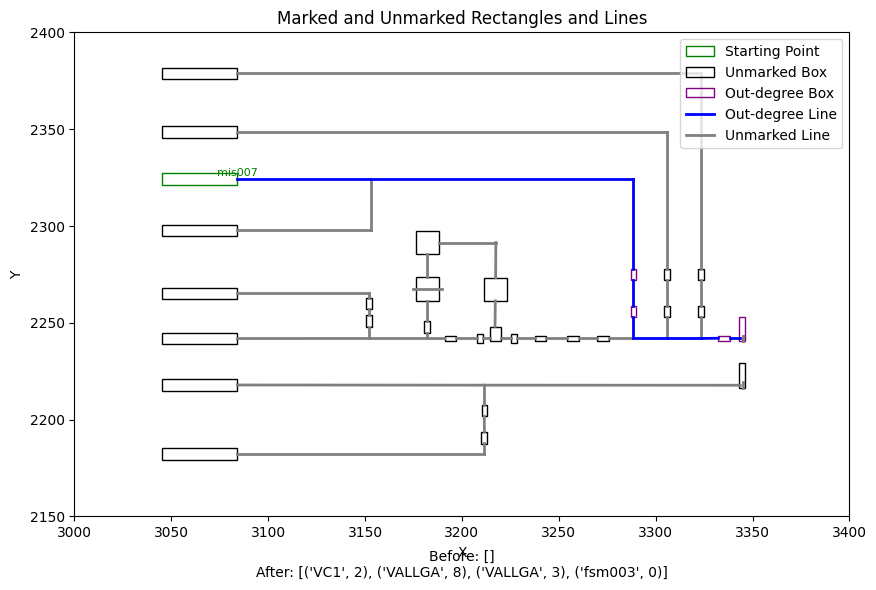

{('VC1', 0): [[8, 9]]}
[('mis007', 1), ('VC1', 0)]
[]
[8, 9]
[('VC1', 0)]
kaishi
jieshu
[('mis007', 1), ('VC1', 0)]
[]
[8, 9]
kaishi
found_blocks {('mis007', 1): [[9, 8]], ('VALLGA', 0): [[10]]}
start_block ('VC1', 0)
block_name_id_relationship [('mis007', 1), ('VC1', 0), ('VALLGA', 0)]
before_path []
after_path [8, 9, 10]
values_after [('VALLGA', 0)]
kaishi
found_blocks {('VC1', 0): [[10]], ('mis007', 2): [[11, 38]], ('VALLGA', 1): [[11, 12, 37]], ('VALLGA', 4): [[11, 12, 13]]}
start_block ('VALLGA', 0)
block_name_id_relationship [('mis007', 1), ('VC1', 0), ('VALLGA', 0), ('VALLGA', 4), ('VALLGA', 1)]
before_path []
after_path [8, 9, 10, 11, 12, 37, 13]
values_after [('VALLGA', 4), ('VALLGA', 1)]
kaishi
found_blocks {('PIP2', 0): [[15]], ('VALLGA', 4): [[37, 13]], ('mis007', 2): [[37, 12, 38]], ('VALLGA', 0): [[37, 12, 11]]}
start_block ('VALLGA', 1)
block_name_id_relationship [('mis007', 1), ('VC1', 0), ('VALLGA', 0), ('VALLGA', 4), ('VALLGA', 1), ('PIP2', 0)]
before_path []
after_pa

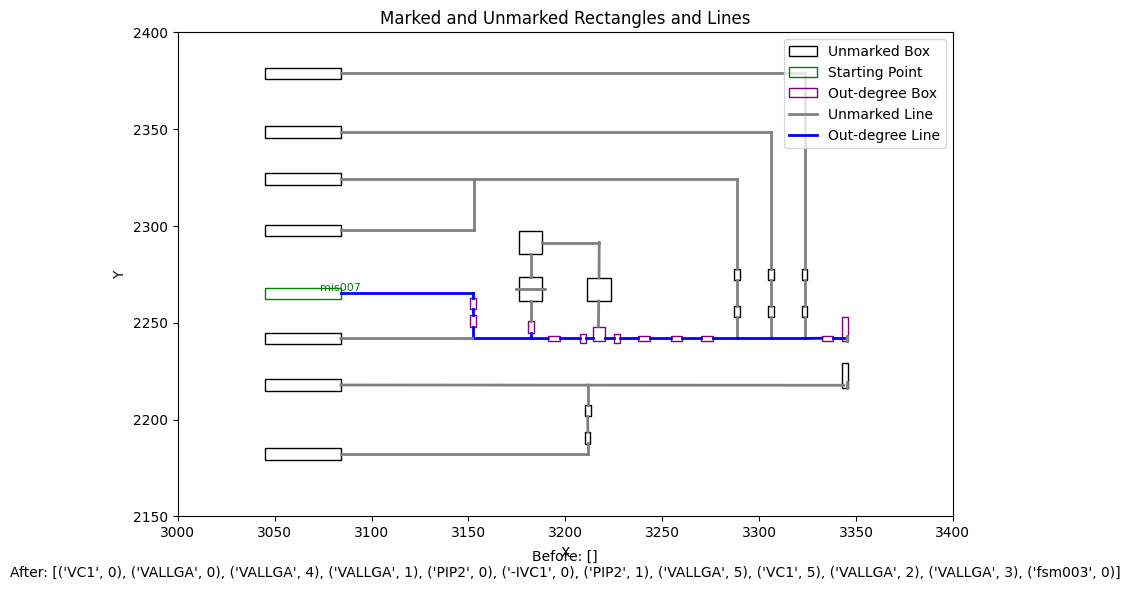

{('VALLGA', 1): [[38, 12, 37]], ('VALLGA', 4): [[38, 12, 13]], ('VALLGA', 0): [[38, 11]]}
[('mis007', 2), ('VALLGA', 4), ('VALLGA', 1)]
[]
[38, 12, 37, 13]
[('VALLGA', 4), ('VALLGA', 1)]
kaishi
jieshu
[('mis007', 2), ('VALLGA', 4), ('VALLGA', 1)]
[]
[38, 12, 37, 13]
kaishi
found_blocks {('PIP2', 0): [[15]], ('VALLGA', 4): [[37, 13]], ('mis007', 2): [[37, 12, 38]], ('VALLGA', 0): [[37, 12, 11]]}
start_block ('VALLGA', 1)
block_name_id_relationship [('mis007', 2), ('VALLGA', 4), ('VALLGA', 1), ('PIP2', 0)]
before_path []
after_path [38, 12, 37, 13, 15]
values_after [('PIP2', 0)]
kaishi
found_blocks {('VALLGA', 1): [[15]], ('-IVC1', 0): [[16]]}
start_block ('PIP2', 0)
block_name_id_relationship [('mis007', 2), ('VALLGA', 4), ('VALLGA', 1), ('PIP2', 0), ('-IVC1', 0)]
before_path []
after_path [38, 12, 37, 13, 15, 16]
values_after [('-IVC1', 0)]
kaishi
found_blocks {('PIP2', 0): [[16]], ('PIP2', 1): [[17]], ('INS01B', 1): [[39]]}
start_block ('-IVC1', 0)
block_name_id_relationship [('mis007

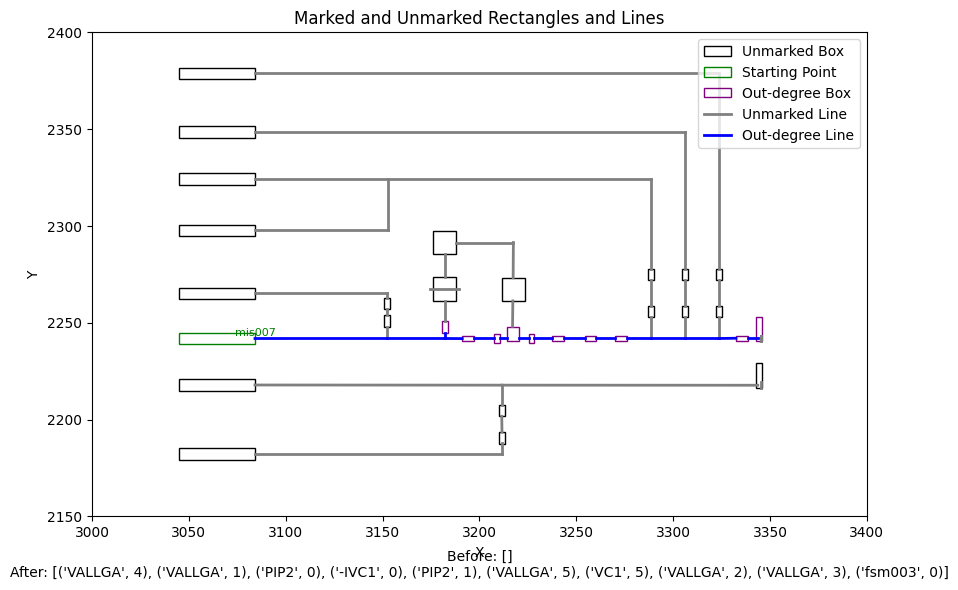

{('fsm003', 1): [[24, 41]], ('VALLGA', 9): [[24, 4]]}
[('mis007', 3), ('VALLGA', 9), ('fsm003', 1)]
[]
[24, 41, 4]
[('VALLGA', 9), ('fsm003', 1)]
kaishi
jieshu
[('mis007', 3), ('VALLGA', 9), ('fsm003', 1)]
[]
[24, 41, 4]
kaishi
found_blocks {('mis007', 3): [[41, 24]], ('VALLGA', 9): [[41, 4]]}
start_block ('fsm003', 1)
block_name_id_relationship [('mis007', 3), ('VALLGA', 9), ('fsm003', 1)]
before_path []
after_path [24, 41, 4]
values_after []
kaishi
jieshu
[('mis007', 3), ('VALLGA', 9), ('fsm003', 1)]
[]
[24, 41, 4]


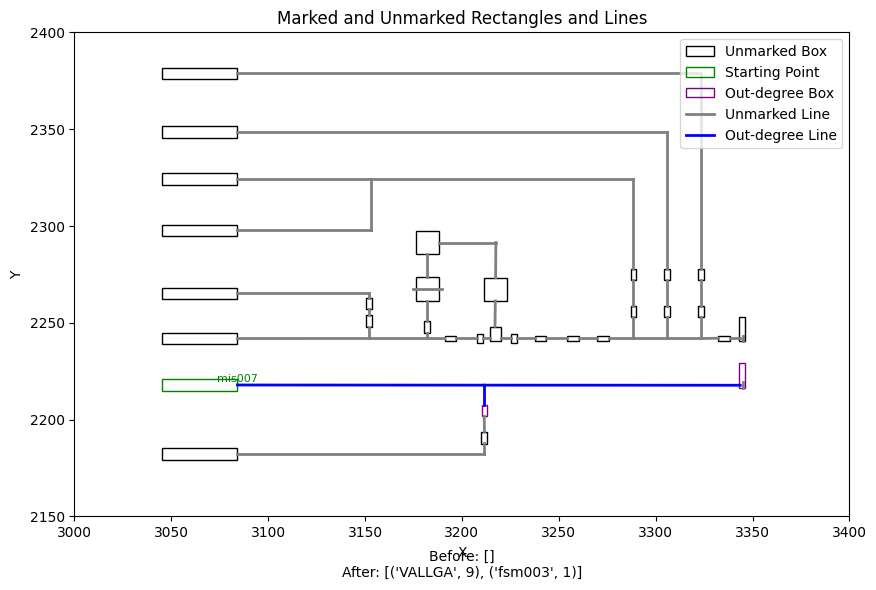

{('VC1', 1): [[5, 6]]}
[('mis007', 4), ('VC1', 1)]
[]
[5, 6]
[('VC1', 1)]
kaishi
jieshu
[('mis007', 4), ('VC1', 1)]
[]
[5, 6]
kaishi
found_blocks {('mis007', 4): [[6, 5]], ('VALLGA', 9): [[40]]}
start_block ('VC1', 1)
block_name_id_relationship [('mis007', 4), ('VC1', 1), ('VALLGA', 9)]
before_path []
after_path [5, 6, 40]
values_after [('VALLGA', 9)]
kaishi
found_blocks {('fsm003', 1): [[4, 41]], ('mis007', 3): [[4, 24]], ('VC1', 1): [[40]]}
start_block ('VALLGA', 9)
block_name_id_relationship [('mis007', 4), ('VC1', 1), ('VALLGA', 9), ('fsm003', 1)]
before_path []
after_path [5, 6, 40, 4, 41]
values_after [('fsm003', 1)]
kaishi
found_blocks {('mis007', 3): [[41, 24]], ('VALLGA', 9): [[41, 4]]}
start_block ('fsm003', 1)
block_name_id_relationship [('mis007', 4), ('VC1', 1), ('VALLGA', 9), ('fsm003', 1)]
before_path []
after_path [5, 6, 40, 4, 41]
values_after []
kaishi
jieshu
[('mis007', 4), ('VC1', 1), ('VALLGA', 9), ('fsm003', 1)]
[]
[5, 6, 40, 4, 41]


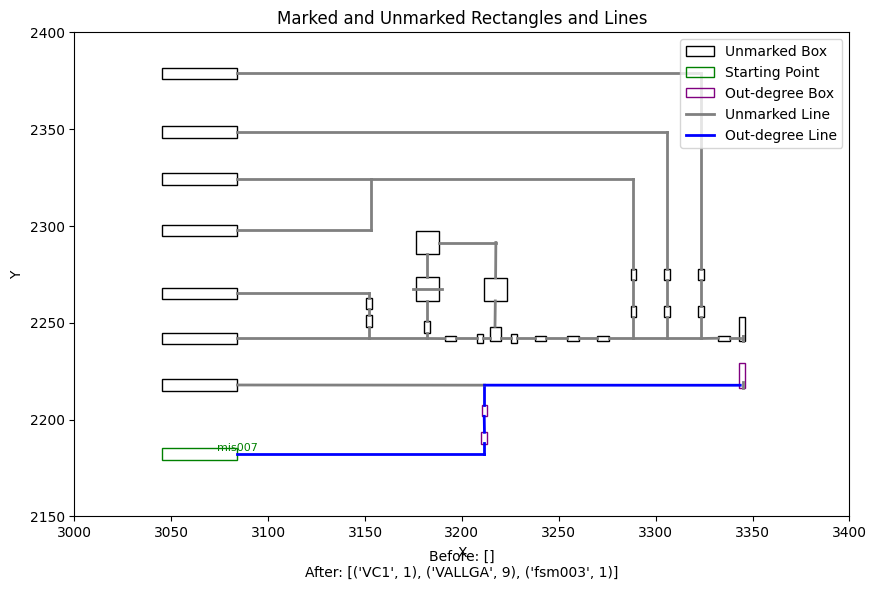

{('mis007', 0): [[26, 25, 42]], ('VC1', 2): [[26, 25, 3, 2]]}
[('mis007', 5), ('VC1', 2)]
[]
[26, 25, 3, 2]
[('VC1', 2)]
kaishi
jieshu
[('mis007', 5), ('VC1', 2)]
[]
[26, 25, 3, 2]
kaishi
found_blocks {('VALLGA', 8): [[1]], ('mis007', 0): [[2, 3, 42]], ('mis007', 5): [[2, 3, 25, 26]]}
start_block ('VC1', 2)
block_name_id_relationship [('mis007', 5), ('VC1', 2), ('VALLGA', 8)]
before_path []
after_path [26, 25, 3, 2, 1]
values_after [('VALLGA', 8)]
kaishi
found_blocks {('VALLGA', 3): [[0, 43, 44, 45]], ('VALLGA', 6): [[0, 43, 44, 31]], ('VALLGA', 7): [[0, 43, 34]], ('VALLGA', 2): [[0, 14]], ('VC1', 2): [[1]]}
start_block ('VALLGA', 8)
block_name_id_relationship [('mis007', 5), ('VC1', 2), ('VALLGA', 8), ('VALLGA', 3)]
before_path []
after_path [26, 25, 3, 2, 1, 0, 43, 44, 45]
values_after [('VALLGA', 3)]
kaishi
found_blocks {('fsm003', 0): [[7]], ('VALLGA', 7): [[45, 44, 34]], ('VALLGA', 2): [[45, 44, 43, 14]], ('VALLGA', 8): [[45, 44, 43, 0]], ('VALLGA', 6): [[45, 31]]}
start_block ('V

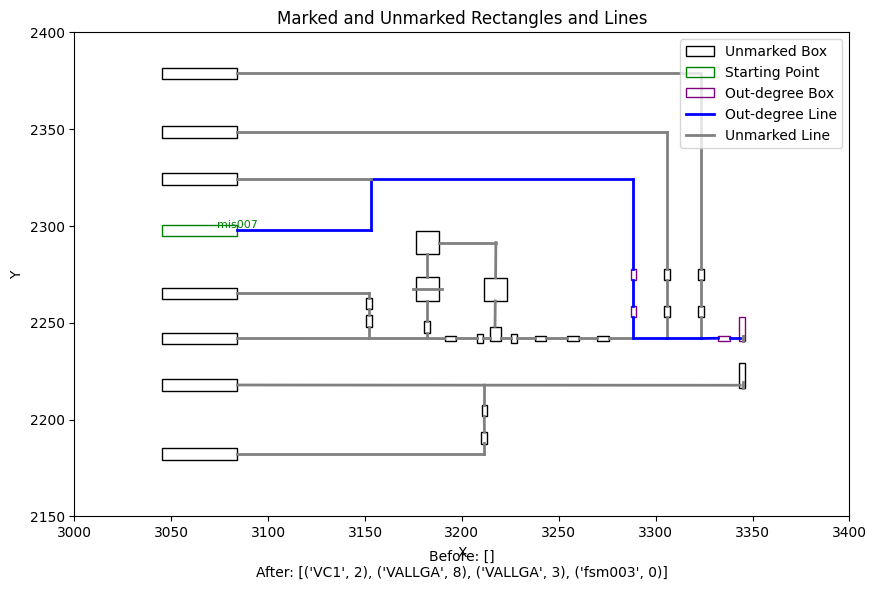

{('VC1', 3): [[27, 32]]}
[('mis007', 6), ('VC1', 3)]
[]
[27, 32]
[('VC1', 3)]
kaishi
jieshu
[('mis007', 6), ('VC1', 3)]
[]
[27, 32]
kaishi
found_blocks {('mis007', 6): [[32, 27]], ('VALLGA', 7): [[33]]}
start_block ('VC1', 3)
block_name_id_relationship [('mis007', 6), ('VC1', 3), ('VALLGA', 7)]
before_path []
after_path [27, 32, 33]
values_after [('VALLGA', 7)]
kaishi
found_blocks {('VC1', 3): [[33]], ('VALLGA', 3): [[34, 44, 45]], ('VALLGA', 6): [[34, 44, 31]], ('VALLGA', 2): [[34, 43, 14]], ('VALLGA', 8): [[34, 43, 0]]}
start_block ('VALLGA', 7)
block_name_id_relationship [('mis007', 6), ('VC1', 3), ('VALLGA', 7), ('VALLGA', 3)]
before_path []
after_path [27, 32, 33, 34, 44, 45]
values_after [('VALLGA', 3)]
kaishi
found_blocks {('fsm003', 0): [[7]], ('VALLGA', 7): [[45, 44, 34]], ('VALLGA', 2): [[45, 44, 43, 14]], ('VALLGA', 8): [[45, 44, 43, 0]], ('VALLGA', 6): [[45, 31]]}
start_block ('VALLGA', 3)
block_name_id_relationship [('mis007', 6), ('VC1', 3), ('VALLGA', 7), ('VALLGA', 3), 

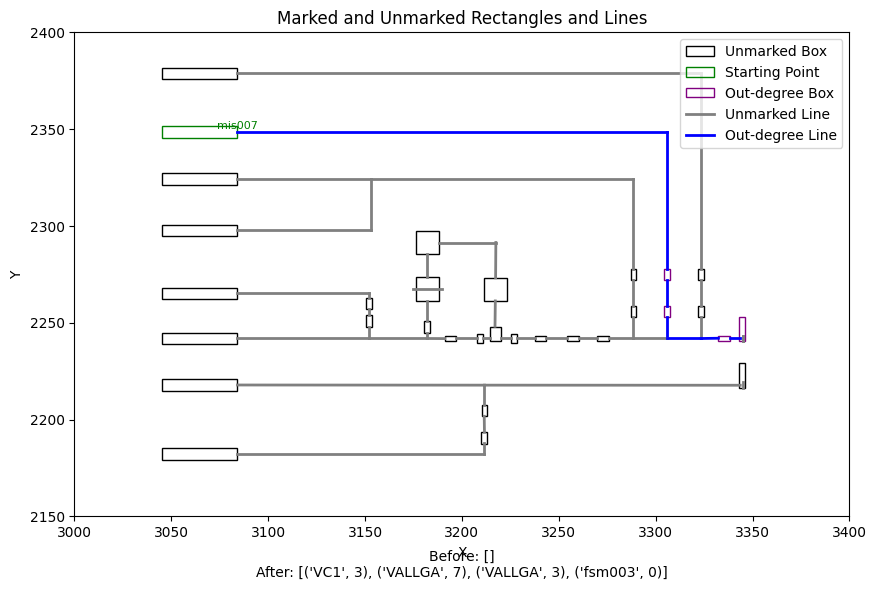

{('VC1', 4): [[28, 29]]}
[('mis007', 7), ('VC1', 4)]
[]
[28, 29]
[('VC1', 4)]
kaishi
jieshu
[('mis007', 7), ('VC1', 4)]
[]
[28, 29]
kaishi
found_blocks {('mis007', 7): [[29, 28]], ('VALLGA', 6): [[30]]}
start_block ('VC1', 4)
block_name_id_relationship [('mis007', 7), ('VC1', 4), ('VALLGA', 6)]
before_path []
after_path [28, 29, 30]
values_after [('VALLGA', 6)]
kaishi
found_blocks {('VC1', 4): [[30]], ('VALLGA', 3): [[31, 45]], ('VALLGA', 7): [[31, 44, 34]], ('VALLGA', 2): [[31, 44, 43, 14]], ('VALLGA', 8): [[31, 44, 43, 0]]}
start_block ('VALLGA', 6)
block_name_id_relationship [('mis007', 7), ('VC1', 4), ('VALLGA', 6), ('VALLGA', 3)]
before_path []
after_path [28, 29, 30, 31, 45]
values_after [('VALLGA', 3)]
kaishi
found_blocks {('fsm003', 0): [[7]], ('VALLGA', 7): [[45, 44, 34]], ('VALLGA', 2): [[45, 44, 43, 14]], ('VALLGA', 8): [[45, 44, 43, 0]], ('VALLGA', 6): [[45, 31]]}
start_block ('VALLGA', 3)
block_name_id_relationship [('mis007', 7), ('VC1', 4), ('VALLGA', 6), ('VALLGA', 3), 

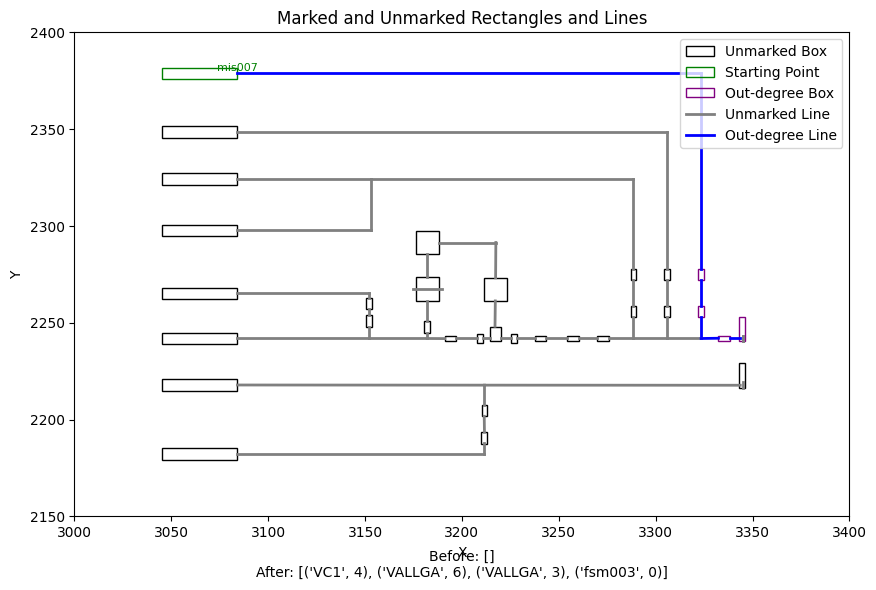

In [173]:
def find_connected_block_by_line(line_id, visited_lines=None, start_block_name=None, start_block_id=None, block_paths=None):
    if visited_lines is None:
        visited_lines = set()  # 使用 set 来避免重复访问
    if block_paths is None:
        block_paths = {}  # 用于存储块和路径的映射
    visited_lines = set()
    # 使用栈来模拟递归
    stack = [(line_id, [], visited_lines)]  # stack 存储 (当前line_id, 当前路径, 已访问的线段)
    while stack:
        current_line_id, path, visited_lines = stack.pop()
        # print("c:",current_line_id, "p:",path, "v:",visited_lines)
        path = path + [current_line_id]  # 更新当前路径

        # 如果该 line_id 已经访问过，跳过
        if current_line_id in visited_lines:
            continue

        # 标记当前 line_id 为已访问
        visited_lines.add(current_line_id)

        # 查找与当前 line_id 相关联的块
        connected_block = find_block_by_line_id(current_line_id)
        # 如果找到了一个连接的块，并且它不是起始块
        if connected_block:
            for b in connected_block:
                if connected_block and (b[0] != start_block_name or b[1] != start_block_id):
                    if b not in block_paths:
                        block_paths[b] = []  # 初始化该块的路径列表
                    block_paths[b].append(path)  # 记录路径
                    continue  # 找到目标块，跳过继续递归

        # 查找与当前 line_id 相交的所有线段
        intersecting_lines = intersections.get(current_line_id, [])
        # print("intersecting_lines",intersecting_lines)

        # 将所有与当前线段相交的线段压入栈中
        for intersection in intersecting_lines:
            intersected_line_id = intersection['line_id']
            if intersected_line_id not in visited_lines:
                stack.append((intersected_line_id, path, visited_lines.copy()))  # 使用路径副本，避免影响其他路径

    # 返回最终的块路径和已访问的线段
    return block_paths, visited_lines


def find_block_by_line_id(line_id):
    blocks = []  # 用于存储所有匹配的块信息
    for item in total_intersected_lines:
        if item['line_id'] == line_id:
            blocks.append((item['block_name'], item['block_id']))  # 将匹配的块添加到列表
    return blocks if blocks else None  # 如果找到匹配项，返回所有匹配的块；否则返回 None



# 查找给定 block_name 和 block_id 的所有相关线段
def find_line_ids_by_block(block_name, block_id):
    line_ids = []
    for item in total_intersected_lines:
        if item['block_name'] == block_name and item['block_id'] == block_id:
            line_ids.append(item['line_id'])
    return line_ids


def insert_before(a, target, value):
    # 查找目标值的位置
    index = a.index(target)
    # 插入新值，目标值的前面是目标值位置的索引
    a.insert(index, value)

def insert_after(a, target, value):
    # 查找目标值的位置
    index = a.index(target)
    # 插入新值，目标值位置后面是目标值位置+1
    a.insert(index + 1, value)

def check_order(a, b):
    # 假设 b 中包含 a 中的两个数字
    if len(b) != 2:
        return "error"  # 如果 b 不是两个数字，返回错误

    # 查找 a 中两个数字的索引
    first_index = a.index(b[0])
    second_index = a.index(b[1])

    # 判断两个数字是否相邻
    if abs(first_index - second_index) == 1:
        if first_index < second_index:
            return 1  # first_index 在 second_index 前
        else:
            return 0  # first_index 在 second_index 后
    else:
        return "error"  # 如果两个数字不相邻，则返回无法判断


def remove_key_by_value(d, value_to_remove):
    # 创建一个列表存储要删除的键
    keys_to_delete = [key for key, value in d.items() if value == value_to_remove]
    
    # 删除匹配的键
    for key in keys_to_delete:
        del d[key]
    
    return d

def get_rotation_for_line_ids(line_ids, insert_point_closest_line):
    rotations = {}
    # 遍历 insert_point_closest_line 中的所有记录
    for key, value in insert_point_closest_line.items():
        # 遍历每个 line_ids 列表中的元素
        for id in value['line_ids']:
            if id in line_ids:
                rotations[id] = value['rotation_angle']
    return rotations

def check_dicts_in_list(dict_list):
    if all(d == dict_list[0] for d in dict_list):
        return dict_list[0]
    else:
        return "error"

def get_line_info_by_id(lines, line_id):
    """
    根据线的id从lines中提取对应的信息
    :param lines: 包含线信息的列表
    :param line_id: 要提取的线id
    :return: 提取的线信息，或None
    """
    for line in lines:
        if line['id'] == line_id:
            geometry = line['geometry']
            # 如果geometry是LineString对象，可以直接获取坐标
            if isinstance(geometry, LineString):
                return {
                    'geometry': geometry,
                    'color': line['color']
                }
            else:
                # 如果geometry是字符串，需要转换为LineString对象
                geometry_coords = parse_geometry(geometry)
                return {
                    'geometry': LineString(geometry_coords),
                    'color': line['color']
                }
    return None


def determine_direction(lines, id1, id2, arrow_direction, arrow_on_line_id):
    """
    判断两条线的指向关系，考虑箭头在哪条线上
    :param lines: 包含线信息的列表
    :param id1: 第一条线的id
    :param id2: 第二条线的id
    :param arrow_direction: 箭头方向 ("left", "right", "up", "bottom")
    :param arrow_on_line_id: 箭头在哪条线上（"id1" 或 "id2"）
    :return: 指向关系数据结构，便于后续处理
    """
    line1_info = get_line_info_by_id(lines, id1)
    line2_info = get_line_info_by_id(lines, id2)

    if line1_info is None or line2_info is None:
        return {"error": f"未找到id为{id1}或{id2}的线段"}

    line1 = line1_info['geometry']
    line2 = line2_info['geometry']

    # 获取交点
    intersection = line1.intersection(line2)
    if intersection.is_empty:
        return {"error": "两条线不相交"}

    # 获取交点的坐标
    intersection_point = (intersection.x, intersection.y)

    # 获取箭头所在线段的起点和终点
    if arrow_on_line_id == id1:
        start_point, end_point = get_arrow_endpoints(line1, arrow_direction)
        # print(start_point, end_point)
    elif arrow_on_line_id == id2:
        start_point, end_point = get_arrow_endpoints(line2, arrow_direction)
    else:
        return {"error": "无效的箭头所在线段ID"}
    # print( intersection.x , start_point[0])
    # 判断箭头方向和交点相对起点的位置
    is_towards_arrow = False
    if arrow_direction == "left":
        is_towards_arrow = intersection.x < start_point[0]
    elif arrow_direction == "right":
        is_towards_arrow = intersection.x > start_point[0]
    elif arrow_direction == "up":
        is_towards_arrow = intersection.y > start_point[1]
    elif arrow_direction == "bottom":
        is_towards_arrow = intersection.y < start_point[1]
    else:
        return {"error": "无效的箭头方向"}

    # 基于箭头方向和交点位置来决定流动方向
    if is_towards_arrow:
        # 如果一致，流动方向是由基准线段指向另一条线段
        flow_info = {
            "flow_direction": f"从线{id1}到线{id2}" if arrow_on_line_id == id1 else f"从线{id2}到线{id1}",
            "from_line_id": id1 if arrow_on_line_id == id1 else id2,
            "to_line_id": id2 if arrow_on_line_id == id1 else id1
        }
    else:
        # 否则，流动方向是由另一条线段指向基准线段
        flow_info = {
            "flow_direction": f"从线{id2}到线{id1}" if arrow_on_line_id == id1 else f"从线{id1}到线{id2}",
            "from_line_id": id2 if arrow_on_line_id == id1 else id1,
            "to_line_id": id1 if arrow_on_line_id == id1 else id2
        }
    return flow_info

def get_arrow_endpoints(line, arrow_direction):
    """
    根据箭头方向来获取线段的起点和终点
    :param line: 线段
    :param arrow_direction: 箭头方向
    :return: 起点和终点
    """
    start_point, end_point = line.coords[0], line.coords[-1]
    
    if arrow_direction == "left":
        # 起点在右，终点在左
        if start_point[0] < end_point[0]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "right":
        # 起点在左，终点在右
        if start_point[0] > end_point[0]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "up":
        # 起点在下，终点在上
        if start_point[1] > end_point[1]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "bottom":
        # 起点在上，终点在下
        if start_point[1] < end_point[1]:
            start_point, end_point = end_point, start_point

    return start_point, end_point

def get_arrow_direction_by_rotation(dic):
    """
    根据旋转角度确定箭头的方向
    :param rotation_angle: 旋转角度
    :return: 箭头方向 ("right", "up", "left", "bottom")
    """
    for id,rotation_angle in dic.items():
    
        if abs(rotation_angle) < 45 or abs(rotation_angle) > 315:
            dic[id]="right"
        elif 45 <= abs(rotation_angle) < 135:
            dic[id]= "up"
        elif 135 <= abs(rotation_angle) < 225:
            dic[id]= "left"
        elif 225 <= abs(rotation_angle) < 315:
            dic[id]= "bottom"
    return dic  # 默认情况

def two_lines_direction(liness,insert_point_closest_line):
        rotations = get_rotation_for_line_ids(liness, insert_point_closest_line)
        line_id_direction=get_arrow_direction_by_rotation(rotations)
        line_id1 = liness[0]
        line_id2 = liness[1]
        result_list = []
        for index, j in enumerate(line_id_direction.values()):
            arrow_on_line_id = list(line_id_direction.keys())[index]
            arrow_direction = j
            # print("arrow_direction, arrow_on_line_id:",arrow_direction, arrow_on_line_id)
            result = determine_direction(lines, line_id1, line_id2, arrow_direction, arrow_on_line_id)
            result_list.append(result)
            result = check_dicts_in_list(result_list)
        return result

def find_direction(start, end, direction, rectangles_info):
    # 查找给定name和id的矩形信息
    def get_rectangle_info(name, id):
        for rect in rectangles_info:
            if rect['name'] == name and rect['id'] == id:
                return rect['bounding_box']
        return None

    start_name, start_id = start
    end_name, end_id = end
    
    # 获取起始矩形和目标矩形的bounding_box
    start_bbox = get_rectangle_info(start_name, start_id)
    end_bbox = get_rectangle_info(end_name, end_id)
    
    if not start_bbox or not end_bbox:
        return "Invalid input: start or end block not found."
    
    # 解析bounding_box
    x1_start, y1_start, x2_start, y2_start = start_bbox
    x1_end, y1_end, x2_end, y2_end = end_bbox

    # 根据方向判断是否符合流向条件
    if direction == 'right':
        # 判断第一个block的右边界小于第二个block的左边界
        if x2_start < x1_end:
            return 1
        else:
            return 0
    
    elif direction == 'left':
        # 判断第一个block的左边界大于第二个block的右边界
        if x1_start > x2_end:
            return 1
        else:
            return 0
    
    elif direction == 'up':
        # 判断第一个block的上边界大于第二个block的下边界
        if y1_start < y2_end:
            return 1
        else:
            return 0
    
    elif direction == 'bottom':
        # 判断第一个block的下边界小于第二个block的上边界
        if y2_start > y1_end:
            return 1
        else:
            return 0
    
    else:
        return "Invalid direction input."

# 示例调用：
def block_to_path_to_block(block_name,block_id,total_intersected_lines):

    # 查找与 block_name 和 block_id 相关的所有 line_id
    initial_line_ids = find_line_ids_by_block(block_name, block_id)
    
    if not initial_line_ids:
        print(f"No lines found for block {block_name}, block_id {block_id}.")
    else:
        # 通过栈模拟递归查找与这些 line_id 相关联的块
        found_blocks = {}  # 存储每个找到的块和路径
        visited_lines = set()  # 使用 set 来记录已访问的 line_id
        for line_id in initial_line_ids:
            # 对于每个 line_id，查找是否与其他块连接
            connected_block_paths, visited_lines = find_connected_block_by_line(
                line_id, visited_lines, start_block_name=block_name, start_block_id=block_id, block_paths=found_blocks
            )
            
            if connected_block_paths:
                found_blocks = connected_block_paths  # 更新找到的块和路径
        
        if found_blocks:
            # for block, liness in found_blocks.items():
            #     print(f"Block: {block[0]} (ID: {block[1]})")
            #     for line in liness:
            #         print(f"  Passed line_ids: {line}")
            return found_blocks
        else:
            print(f"No connected block found for block_name '{block_name}' and block_id {block_id}.")
            print(f"Visited line_ids: {visited_lines}")
            return 0

def a(found_blocks,insert_point_closest_line,block_name_id_relationships,before_path,after_path,start_block,flow):
    block_name_id_relationships_copy = copy.deepcopy(block_name_id_relationships)
    for block,liness in found_blocks.items():
        # print(block)
        # print(liness[0])
        if len(liness[0]) == 1:
            rotations = get_rotation_for_line_ids(liness[0], insert_point_closest_line)
            # print(rotations)
            line_id_direction=get_arrow_direction_by_rotation(rotations)
            result = find_direction(start_block,block,list(line_id_direction.values())[0],rectangles_info)
            if flow == "both":
                # print(find_direction)
                if result:
                    insert_after(block_name_id_relationships_copy,start_block,block)
                    after_path.append(liness[0][0])
                else :
                    insert_before(block_name_id_relationships_copy,start_block,block)
                    before_path.append(liness[0][0])
            elif flow == "before":
                # print(find_direction)
                if result:
                    # insert_after(block_name_id_relationships_copy,start_block,block)
                    # after_path.append(liness[0][0])
                    pass
                else :
                    insert_before(block_name_id_relationships_copy,start_block,block)
                    before_path.append(liness[0][0])
            else :
                # print(find_direction)
                if result:
                    insert_after(block_name_id_relationships_copy,start_block,block)
                    after_path.append(liness[0][0])
                # else :
                #     insert_before(block_name_id_relationships_copy,start_block,block)
                #     before_path.append(liness[0][0])

        elif len(liness[0]) == 2:
            result_list = two_lines_direction(liness[0],insert_point_closest_line)
            if result_list == "error" :
               pass 
            else :
                # print(result_list)
                list1 = []
                list1.append(result_list['from_line_id'])
                list1.append(result_list['to_line_id'])
                result = check_order(liness[0], list1)
                if flow == "both":
                    if result:
                        insert_after(block_name_id_relationships_copy,start_block,block)
                        after_path.append(result_list['from_line_id'])
                        after_path.append(result_list['to_line_id'])
                    else :
                        insert_before(block_name_id_relationships_copy,start_block,block)
                        before_path.append(result_list['from_line_id'])
                        before_path.append(result_list['to_line_id'])
                elif flow == "before":
                    if result:
                        # insert_after(block_name_id_relationships_copy,start_block,block)
                        # after_path.append(result_list['from_line_id'])
                        # after_path.append(result_list['to_line_id'])
                        pass
                    else :
                        insert_before(block_name_id_relationships_copy,start_block,block)
                        before_path.append(result_list['from_line_id'])
                        before_path.append(result_list['to_line_id'])  
                else :
                    if result:
                        insert_after(block_name_id_relationships_copy,start_block,block)
                        after_path.append(result_list['from_line_id'])
                        after_path.append(result_list['to_line_id'])
                    # else :
                    #     insert_before(block_name_id_relationships_copy,start_block,block)
                    #     before_path.append(result_list['from_line_id'])
                    #     before_path.append(result_list['to_line_id'])
                # list2 = block_name_id_relationships_copy
                # return list2,before_path,after_path
        else:
            list1 = []
            for i in range(len(liness[0])-1):
                result_list = two_lines_direction(liness[0][i:i+2],insert_point_closest_line)
                if result_list == "error" :
                    break
                if i == 0 :
                    list1.append(result_list['from_line_id'])
                    list1.append(result_list['to_line_id'])

            if result_list != "error":
                result = check_order(liness[0], list1)
                # print("liness[0]:",liness[0],"list1:",list1,result)
                if flow == "both":
                    if result:
                            insert_after(block_name_id_relationships_copy,start_block,block)
                            after_path.extend(liness[0])
                    else :
                            insert_before(block_name_id_relationships_copy,start_block,block)
                            before_path.extend(liness[0])
                elif flow == "before":
                    if result:
                            # insert_after(block_name_id_relationships_copy,start_block,block)
                            # after_path.extend(liness[0])
                        pass
                    else :
                            insert_before(block_name_id_relationships_copy,start_block,block)
                            before_path.extend(liness[0])
                else :
                    if result:
                            insert_after(block_name_id_relationships_copy,start_block,block)
                            after_path.extend(liness[0])
                    # else :
                    #         insert_before(block_name_id_relationships_copy,start_block,block)
                    #         before_path.extend(liness[0])
                # list2 = block_name_id_relationships_copy
    return list(dict.fromkeys(block_name_id_relationships_copy)),list(dict.fromkeys(before_path)),list(dict.fromkeys(after_path))

def process_block_after(values_after, block_name_id_relationship, max_iterations, iteration_count=0, flow="after", before_path=None, after_path=None):
    print("kaishi")
    
    # 如果 values_before 为空或达到最大迭代次数，则停止递归
    if not values_after or iteration_count >= max_iterations:
        if iteration_count >= max_iterations:
            print("Reached max iterations, terminating to avoid dead loop.")
        return  block_name_id_relationship, before_path, after_path

    # 递增迭代次数
    iteration_count += 1

    # 取出当前处理的块 (values_before 中的第一个块)
    for start_block in reversed(values_after):
    
        block_name = start_block[0]
        block_id = start_block[1]
        
        found_blocks = block_to_path_to_block(block_name,block_id,total_intersected_lines)
        # 对每个键，保留长度最短的值
        for key in found_blocks:
            # 对每个键的列表进行排序，选择最短的列表
            found_blocks[key] = [min(found_blocks[key], key=len)]
        if found_blocks:  # 确保 found_blocks 非空
            print("found_blocks",found_blocks)
            block_name_id_relationship, before_path, after_path = a(
                found_blocks, insert_point_closest_line, block_name_id_relationship, before_path, after_path, start_block, flow
            )
            
            print("start_block", start_block)
            print("block_name_id_relationship", block_name_id_relationship)
            print("before_path", before_path)
            print("after_path", after_path)

            # 更新 values_before 以去掉当前处理的 start_block
            start_block_index = block_name_id_relationship.index(start_block)
            values_after = block_name_id_relationship[start_block_index+1:]
            
            print("values_after", values_after)

            # 递归调用 process_block 处理下一个块
            return process_block_after(values_after, block_name_id_relationship, max_iterations, iteration_count, flow, before_path, after_path)
            
def process_block_before(values_before, block_name_id_relationship, max_iterations, iteration_count=0, flow="before", before_path=None, after_path=None):
    print("kaishi")
    
    # 如果 values_before 为空或达到最大迭代次数，则停止递归
    if not values_before or iteration_count >= max_iterations:
        if iteration_count >= max_iterations:
            print("Reached max iterations, terminating to avoid dead loop.")
        return  block_name_id_relationship, before_path, after_path

    # 递增迭代次数
    iteration_count += 1

    # 取出当前处理的块 (values_before 中的第一个块)
    for start_block in reversed(values_before):
    
        block_name = start_block[0]
        block_id = start_block[1]
        
        found_blocks = block_to_path_to_block(block_name,block_id,total_intersected_lines)
        # 对每个键，保留长度最短的值
        for key in found_blocks:
            # 对每个键的列表进行排序，选择最短的列表
            found_blocks[key] = [min(found_blocks[key], key=len)]
        if found_blocks:  # 确保 found_blocks 非空
            print("found_blocks",found_blocks)
            block_name_id_relationship, before_path, after_path = a(
                found_blocks, insert_point_closest_line, block_name_id_relationship, before_path, after_path, start_block, flow
            )
            
            print("start_block", start_block)
            print("block_name_id_relationship", block_name_id_relationship)
            print("before_path", before_path)
            print("after_path", after_path)

            # 更新 values_before 以去掉当前处理的 start_block
            start_block_index = block_name_id_relationship.index(start_block)
            values_before = block_name_id_relationship[:start_block_index]
            
            print("values_before", values_before)

            # 递归调用 process_block 处理下一个块
            return process_block_before(values_before, block_name_id_relationship, max_iterations, iteration_count, flow, before_path, after_path)
from collections import Counter
block_names = [point[3] for point in insert_points_other]
block_count = Counter(block_names)
block_name = 'mis007'
for block_id in range(block_count.get(block_name, 0)):
    # block_name = 'INS07_new'
    # block_id = 0
    flow = "both"
    
    # block_id = 2
    start_block=(block_name,block_id)
    block_name_id_relationship = [(block_name,block_id)]
    before_path =[]
    after_path = []
    found_blocks = block_to_path_to_block(block_name,block_id,total_intersected_lines)
    # 对每个键，保留长度最短的值
    for key in found_blocks:
        # 对每个键的列表进行排序，选择最短的列表
        found_blocks[key] = [min(found_blocks[key], key=len)]
    print(found_blocks)
    if found_blocks != 0 :
    # found_blocks
        block_name_id_relationship,before_path,after_path = a(found_blocks,insert_point_closest_line,block_name_id_relationship,before_path,after_path,start_block,flow)
        print(block_name_id_relationship)
        print(before_path)
        print(after_path)
    
    start_block_index = block_name_id_relationship.index(start_block)
    values_before = block_name_id_relationship[:start_block_index]
    values_after = block_name_id_relationship[start_block_index + 1:]
    # print(values_before)
    print(values_after)
    max_iterations = 10  # 设定最大迭代次数，防止死循环
    iteration_count = 0   
    block_name_id_relationship_b, before_path, after_path = process_block_before(values_before, block_name_id_relationship, max_iterations, iteration_count=0, flow="before", before_path=before_path, after_path=after_path)    
    print("jieshu")
    print(block_name_id_relationship_b)
    print(before_path)
    print(after_path)
    block_name_id_relationship_a, before_path, after_path = process_block_after(values_after, block_name_id_relationship, max_iterations, iteration_count=0, flow="after", before_path=before_path, after_path=after_path)    
    print("jieshu")
    print(block_name_id_relationship_a)
    print(before_path)
    print(after_path)
    
    start_index_b = block_name_id_relationship_b.index(start_block)
    start_index_a = block_name_id_relationship_a.index(start_block)
    block_name_id_relationship_before = block_name_id_relationship_b[:start_index_b]
    block_name_id_relationship_after = block_name_id_relationship_a[start_index_a + 1:]
    # 创建图形
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制矩形框（已标记的为红色，未标记的为黑色）
    for rect in rectangles_info:
        x, y = rect['bounding_box'][2], rect['bounding_box'][3]
        if (rect['name'], rect['id']) in block_name_id_relationship_before:
            # 已标记的矩形框为红色
            ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                           rect['bounding_box'][2] - rect['bounding_box'][0],
                                           rect['bounding_box'][3] - rect['bounding_box'][1],
                                           linewidth=1, edgecolor='red', facecolor='none', label='In-degree Box'))
        elif (rect['name'], rect['id']) in block_name_id_relationship_after:
            # 已标记的矩形框为紫色
            ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                           rect['bounding_box'][2] - rect['bounding_box'][0],
                                           rect['bounding_box'][3] - rect['bounding_box'][1],
                                           linewidth=1, edgecolor='purple', facecolor='none', label='Out-degree Box'))
        elif (rect['name'], rect['id']) == start_block:
            # 已标记的矩形框为绿色（出发点）
            ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                           rect['bounding_box'][2] - rect['bounding_box'][0],
                                           rect['bounding_box'][3] - rect['bounding_box'][1],
                                           linewidth=1, edgecolor='green', facecolor='none', label='Starting Point'))
            ax.text(x, y, f'{rect["name"]}', color='green', fontsize=8, ha='center', va='center')
        else:
            # 未标记的矩形框为黑色
            ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                           rect['bounding_box'][2] - rect['bounding_box'][0],
                                           rect['bounding_box'][3] - rect['bounding_box'][1],
                                           linewidth=1, edgecolor='black', facecolor='none', label='Unmarked Box'))
    
    # 绘制线段（已标记的为橙色，未标记的为灰色）
    for line in lines:
        if line['id'] in before_path:
            x, y = line['geometry'].xy
            ax.plot(x, y, color='orange', lw=2, label='In-degree Line')  # 已标记的线段为橙色
        elif line['id'] in after_path:
            x, y = line['geometry'].xy
            ax.plot(x, y, color='blue', lw=2, label='Out-degree Line')  # 已标记的线段为蓝色
        else:
            x, y = line['geometry'].xy
            ax.plot(x, y, color='gray', lw=2, label='Unmarked Line')  # 未标记的线段为灰色
    
    # 设置轴范围
    ax.set_xlim(3000, 3400)
    ax.set_ylim(2150, 2400)
    
    # 添加图例
    handles, labels = ax.get_legend_handles_labels()
    # 去除重复的标签（因为每次循环都会添加标签）
    unique_handles = []
    unique_labels = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    
    ax.legend(unique_handles, unique_labels, loc='upper right')
    
    # 在图像底部添加 block_name_id_relationship_before 和 block_name_id_relationship_after 的内容
    bottom_text = f"Before: {block_name_id_relationship_before}\nAfter: {block_name_id_relationship_after}"
    plt.text(0.5, -0.1, bottom_text, ha='center', va='center', fontsize=10, transform=ax.transAxes)
    
    # 显示并保存图像
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Marked and Unmarked Rectangles and Lines')
    plt.savefig(f'in_out_{block_name}_{block_id}.png', bbox_inches='tight')
    plt.show()


In [139]:
start_index_b = block_name_id_relationship_b.index(start_block)
start_index_a = block_name_id_relationship_a.index(start_block)
block_name_id_relationship_before = block_name_id_relationship_b[:start_index_b]
block_name_id_relationship_after = block_name_id_relationship_a[start_index_a + 1:]

In [140]:
block_name_id_relationship_before = block_name_id_relationship_b[:start_index_b]
block_name_id_relationship_after = block_name_id_relationship_a[start_index_a + 1:]

In [141]:
block_name_id_relationship_before = block_name_id_relationship_b[:-2]

In [142]:
block_name_id_relationship_after = block_name_id_relationship_a[2:]

In [143]:
block_name_id_relationship_a[1]

('VC1', 2)

In [144]:
block_name_id_relationship_before

[]

In [145]:
block_name_id_relationship_after

[('VALLGA', 8), ('VALLGA', 3), ('fsm003', 0)]

In [146]:
before_path 

[]

In [147]:
after_path 

[42, 3, 2, 1, 0, 43, 44, 45, 7]

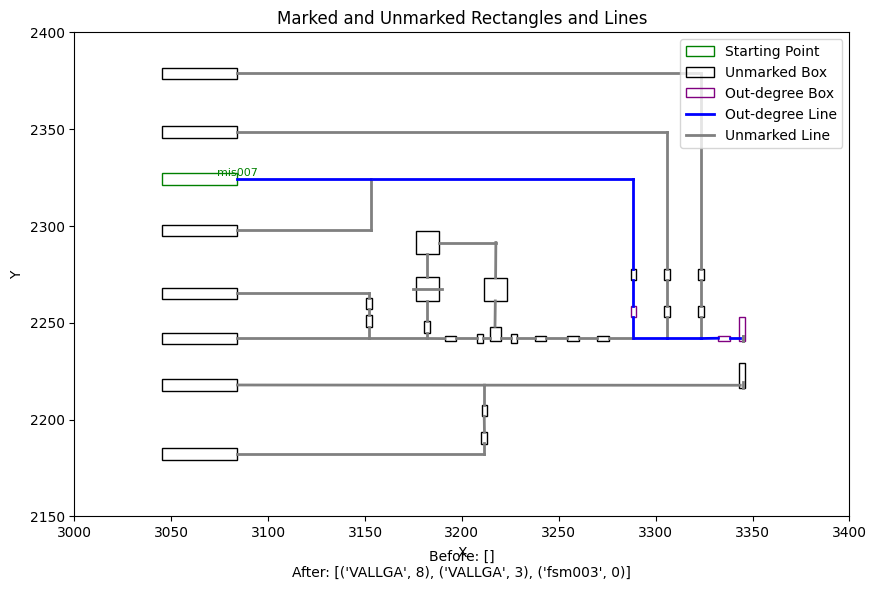

In [148]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import LineString


# 创建图形
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制矩形框（已标记的为红色，未标记的为黑色）
for rect in rectangles_info:
    x, y = rect['bounding_box'][2], rect['bounding_box'][3]
    if (rect['name'], rect['id']) in block_name_id_relationship_before:
        # 已标记的矩形框为红色
        ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                       rect['bounding_box'][2] - rect['bounding_box'][0],
                                       rect['bounding_box'][3] - rect['bounding_box'][1],
                                       linewidth=1, edgecolor='red', facecolor='none', label='In-degree Box'))
    elif (rect['name'], rect['id']) in block_name_id_relationship_after:
        # 已标记的矩形框为紫色
        ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                       rect['bounding_box'][2] - rect['bounding_box'][0],
                                       rect['bounding_box'][3] - rect['bounding_box'][1],
                                       linewidth=1, edgecolor='purple', facecolor='none', label='Out-degree Box'))
    elif (rect['name'], rect['id']) == start_block:
        # 已标记的矩形框为绿色（出发点）
        ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                       rect['bounding_box'][2] - rect['bounding_box'][0],
                                       rect['bounding_box'][3] - rect['bounding_box'][1],
                                       linewidth=1, edgecolor='green', facecolor='none', label='Starting Point'))
        ax.text(x, y, f'{rect["name"]}', color='green', fontsize=8, ha='center', va='center')
    else:
        # 未标记的矩形框为黑色
        ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                       rect['bounding_box'][2] - rect['bounding_box'][0],
                                       rect['bounding_box'][3] - rect['bounding_box'][1],
                                       linewidth=1, edgecolor='black', facecolor='none', label='Unmarked Box'))

# 绘制线段（已标记的为橙色，未标记的为灰色）
for line in lines:
    if line['id'] in before_path:
        x, y = line['geometry'].xy
        ax.plot(x, y, color='orange', lw=2, label='In-degree Line')  # 已标记的线段为橙色
    elif line['id'] in after_path:
        x, y = line['geometry'].xy
        ax.plot(x, y, color='blue', lw=2, label='Out-degree Line')  # 已标记的线段为蓝色
    else:
        x, y = line['geometry'].xy
        ax.plot(x, y, color='gray', lw=2, label='Unmarked Line')  # 未标记的线段为灰色

# 设置轴范围
ax.set_xlim(3000, 3400)
ax.set_ylim(2150, 2400)

# 添加图例
handles, labels = ax.get_legend_handles_labels()
# 去除重复的标签（因为每次循环都会添加标签）
unique_handles = []
unique_labels = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

ax.legend(unique_handles, unique_labels, loc='upper right')

# 在图像底部添加 block_name_id_relationship_before 和 block_name_id_relationship_after 的内容
bottom_text = f"Before: {block_name_id_relationship_before}\nAfter: {block_name_id_relationship_after}"
plt.text(0.5, -0.1, bottom_text, ha='center', va='center', fontsize=10, transform=ax.transAxes)

# 显示并保存图像
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Marked and Unmarked Rectangles and Lines')
plt.savefig('marked_and_unmarked_rectangles_and_lines_with_legend_and_text.png', bbox_inches='tight')
plt.show()


In [149]:
total_intersected_lines

[{'block_id': 0,
  'block_name': 'mis007',
  'line_id': 42,
  'color': 'red',
  'intersection': <LINESTRING (3084.162 2324.173, 3085.162 2324.173)>,
  'position': 'crossing'},
 {'block_id': 1,
  'block_name': 'mis007',
  'line_id': 8,
  'color': 'cyan',
  'intersection': <LINESTRING (3084.155 2265.104, 3085.162 2265.104)>,
  'position': 'crossing'},
 {'block_id': 2,
  'block_name': 'mis007',
  'line_id': 38,
  'color': 'cyan',
  'intersection': <LINESTRING (3084.162 2241.846, 3085.162 2241.846)>,
  'position': 'crossing'},
 {'block_id': 3,
  'block_name': 'mis007',
  'line_id': 24,
  'color': 'orange',
  'intersection': <LINESTRING (3085.162 2217.853, 3084.162 2217.854)>,
  'position': 'crossing'},
 {'block_id': 4,
  'block_name': 'mis007',
  'line_id': 5,
  'color': 'yellow',
  'intersection': <LINESTRING (3084.162 2182.209, 3085.162 2182.209)>,
  'position': 'crossing'},
 {'block_id': 5,
  'block_name': 'mis007',
  'line_id': 26,
  'color': 'brown',
  'intersection': <LINESTRING (308

In [150]:
lines

[{'id': 0,
  'geometry': <LINESTRING (3288.558 2241.854, 3288.558 2252.873)>,
  'color': 'blue'},
 {'id': 1,
  'geometry': <LINESTRING (3288.558 2258.873, 3288.558 2271.854)>,
  'color': 'green'},
 {'id': 2,
  'geometry': <LINESTRING (3288.558 2324.173, 3288.558 2277.854)>,
  'color': 'red'},
 {'id': 3,
  'geometry': <LINESTRING (3152.896 2324.173, 3288.558 2324.173)>,
  'color': 'purple'},
 {'id': 4,
  'geometry': <LINESTRING (3211.662 2217.771, 3211.662 2207.632)>,
  'color': 'orange'},
 {'id': 5,
  'geometry': <LINESTRING (3084.162 2182.209, 3211.662 2182.209)>,
  'color': 'yellow'},
 {'id': 6,
  'geometry': <LINESTRING (3211.662 2182.209, 3211.662 2187.684)>,
  'color': 'brown'},
 {'id': 7,
  'geometry': <LINESTRING (3343.662 2241.854, 3338.412 2241.854)>,
  'color': 'pink'},
 {'id': 8,
  'geometry': <LINESTRING (3084.155 2265.104, 3152.253 2265.104)>,
  'color': 'cyan'},
 {'id': 9,
  'geometry': <LINESTRING (3152.253 2265.104, 3152.253 2262.854)>,
  'color': 'magenta'},
 {'id': 10

In [151]:
insert_point_closest_line

{0: {'line_ids': [5], 'rotation_angle': 0, 'is_point_on_line': True},
 1: {'line_ids': [8], 'rotation_angle': 0, 'is_point_on_line': True},
 2: {'line_ids': [44], 'rotation_angle': 0, 'is_point_on_line': True},
 3: {'line_ids': [12], 'rotation_angle': 0, 'is_point_on_line': True},
 4: {'line_ids': [15], 'rotation_angle': 0, 'is_point_on_line': True},
 5: {'line_ids': [17], 'rotation_angle': 0, 'is_point_on_line': True},
 6: {'line_ids': [18], 'rotation_angle': 0, 'is_point_on_line': True},
 7: {'line_ids': [19], 'rotation_angle': 0, 'is_point_on_line': True},
 8: {'line_ids': [20], 'rotation_angle': 0, 'is_point_on_line': True},
 9: {'line_ids': [22], 'rotation_angle': 90.0, 'is_point_on_line': True},
 10: {'line_ids': [24], 'rotation_angle': 0, 'is_point_on_line': False},
 11: {'line_ids': [38], 'rotation_angle': 0, 'is_point_on_line': False},
 12: {'line_ids': [11],
  'rotation_angle': 269.3228010285361,
  'is_point_on_line': True},
 13: {'line_ids': [10],
  'rotation_angle': 269.322

In [152]:
from shapely.geometry import LineString

def get_line_info_by_id(lines, line_id):
    """
    根据线的id从lines中提取对应的信息
    :param lines: 包含线信息的列表
    :param line_id: 要提取的线id
    :return: 提取的线信息，或None
    """
    for line in lines:
        if line['id'] == line_id:
            geometry = line['geometry']
            # 如果geometry是LineString对象，可以直接获取坐标
            if isinstance(geometry, LineString):
                return {
                    'geometry': geometry,
                    'color': line['color']
                }
            else:
                # 如果geometry是字符串，需要转换为LineString对象
                geometry_coords = parse_geometry(geometry)
                return {
                    'geometry': LineString(geometry_coords),
                    'color': line['color']
                }
    return None

def get_arrow_direction_by_rotation(dic):
    """
    根据旋转角度确定箭头的方向
    :param rotation_angle: 旋转角度
    :return: 箭头方向 ("right", "up", "left", "bottom")
    """
    for id,rotation_angle in dic.items():
    
        if abs(rotation_angle) < 45 or abs(rotation_angle) > 315:
            dic[id]="right"
        elif 45 <= abs(rotation_angle) < 135:
            dic[id]= "up"
        elif 135 <= abs(rotation_angle) < 225:
            dic[id]= "left"
        elif 225 <= abs(rotation_angle) < 315:
            dic[id]= "bottom"
    return dic  # 默认情况

def parse_geometry(geometry_str):
    """
    解析 geometry 字符串，提取坐标列表
    :param geometry_str: 例如 'LINESTRING (3343.662 2217.854, 3294.912 2217.854)'
    :return: 坐标列表，形式如 [(3343.662, 2217.854), (3294.912, 2217.854)]
    """
    coords_str = geometry_str.replace("LINESTRING", "").strip()[1:-1]  # 去掉前后括号
    coords = [tuple(map(float, coord.split())) for coord in coords_str.split(",")]
    return coords

def determine_direction(lines, id1, id2, arrow_direction, arrow_on_line_id):
    """
    判断两条线的指向关系，考虑箭头在哪条线上
    :param lines: 包含线信息的列表
    :param id1: 第一条线的id
    :param id2: 第二条线的id
    :param arrow_direction: 箭头方向 ("left", "right", "up", "bottom")
    :param arrow_on_line_id: 箭头在哪条线上（"id1" 或 "id2"）
    :return: 指向关系数据结构，便于后续处理
    """
    line1_info = get_line_info_by_id(lines, id1)
    line2_info = get_line_info_by_id(lines, id2)

    if line1_info is None or line2_info is None:
        return {"error": f"未找到id为{id1}或{id2}的线段"}

    line1 = line1_info['geometry']
    line2 = line2_info['geometry']

    # 获取交点
    intersection = line1.intersection(line2)
    if intersection.is_empty:
        return {"error": "两条线不相交"}

    # 获取交点的坐标
    intersection_point = (intersection.x, intersection.y)

    # 获取箭头所在线段的起点和终点
    if arrow_on_line_id == id1:
        start_point, end_point = get_arrow_endpoints(line1, arrow_direction)
        # print(start_point, end_point)
    elif arrow_on_line_id == id2:
        start_point, end_point = get_arrow_endpoints(line2, arrow_direction)
    else:
        return {"error": "无效的箭头所在线段ID"}
    # print( intersection.x , start_point[0])
    # 判断箭头方向和交点相对起点的位置
    is_towards_arrow = False
    if arrow_direction == "left":
        is_towards_arrow = intersection.x < start_point[0]
    elif arrow_direction == "right":
        is_towards_arrow = intersection.x > start_point[0]
    elif arrow_direction == "up":
        is_towards_arrow = intersection.y > start_point[1]
    elif arrow_direction == "bottom":
        is_towards_arrow = intersection.y < start_point[1]
    else:
        return {"error": "无效的箭头方向"}

    # 基于箭头方向和交点位置来决定流动方向
    if is_towards_arrow:
        # 如果一致，流动方向是由基准线段指向另一条线段
        flow_info = {
            "flow_direction": f"从线{id1}到线{id2}" if arrow_on_line_id == id1 else f"从线{id2}到线{id1}",
            "from_line_id": id1 if arrow_on_line_id == id1 else id2,
            "to_line_id": id2 if arrow_on_line_id == id1 else id1
        }
    else:
        # 否则，流动方向是由另一条线段指向基准线段
        flow_info = {
            "flow_direction": f"从线{id2}到线{id1}" if arrow_on_line_id == id1 else f"从线{id1}到线{id2}",
            "from_line_id": id2 if arrow_on_line_id == id1 else id1,
            "to_line_id": id1 if arrow_on_line_id == id1 else id2
        }
    return flow_info

def get_rotation_for_line_ids(line_ids, insert_point_closest_line):
    rotations = {}
    # 遍历 insert_point_closest_line 中的所有记录
    for key, value in insert_point_closest_line.items():
        # 遍历每个 line_ids 列表中的元素
        for id in value['line_ids']:
            if id in line_ids:
                rotations[id] = value['rotation_angle']
    return rotations

def get_arrow_endpoints(line, arrow_direction):
    """
    根据箭头方向来获取线段的起点和终点
    :param line: 线段
    :param arrow_direction: 箭头方向
    :return: 起点和终点
    """
    start_point, end_point = line.coords[0], line.coords[-1]
    
    if arrow_direction == "left":
        # 起点在右，终点在左
        if start_point[0] < end_point[0]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "right":
        # 起点在左，终点在右
        if start_point[0] > end_point[0]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "up":
        # 起点在下，终点在上
        if start_point[1] > end_point[1]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "bottom":
        # 起点在上，终点在下
        if start_point[1] < end_point[1]:
            start_point, end_point = end_point, start_point

    return start_point, end_point
line_id1 = 39
line_id2 = 38
arrow_direction = "up"
arrow_on_line_id = 38  # 假设箭头在line_id1上

result = determine_direction(lines, line_id1, line_id2, arrow_direction, arrow_on_line_id)
print(result)
# {('mis007', 5): [[4, 38, 39]], ('VC1', 2): [[4, 3]]}

{'error': '两条线不相交'}


In [153]:
found_blocks

{('mis007', 5): [[42, 25, 26]], ('VC1', 2): [[42, 3, 2]]}

In [154]:
import copy

In [155]:
def insert_before(a, target, value):
    # 查找目标值的位置
    index = a.index(target)
    # 插入新值，目标值的前面是目标值位置的索引
    a.insert(index, value)

def insert_after(a, target, value):
    # 查找目标值的位置
    index = a.index(target)
    # 插入新值，目标值位置后面是目标值位置+1
    a.insert(index + 1, value)

def check_order(a, b):
    # 假设 b 中包含 a 中的前两个数字
    first_num = b[0]
    second_num = b[1]
    
    # 查找 a 和 b 中这两个数字的位置
    a_first_pos = a.index(first_num)
    a_second_pos = a.index(second_num)
    
    b_first_pos = b.index(first_num)
    b_second_pos = b.index(second_num)
    
    # 判断顺序
    if a_first_pos < a_second_pos and b_first_pos < b_second_pos:
        # return "顺序一致"
        return 1
    elif a_first_pos > a_second_pos and b_first_pos > b_second_pos:
        # return "顺序相反"
        return 0
    else:
        return "顺序不一致"
        # return 

def remove_key_by_value(d, value_to_remove):
    # 创建一个列表存储要删除的键
    keys_to_delete = [key for key, value in d.items() if value == value_to_remove]
    
    # 删除匹配的键
    for key in keys_to_delete:
        del d[key]
    
    return d

def check_dicts_in_list(dict_list):
    if all(d == dict_list[0] for d in dict_list):
        return dict_list[0]
    else:
        return "error"
        
def two_lines_direction(liness,insert_point_closest_line):
        rotations = get_rotation_for_line_ids(liness, insert_point_closest_line)
        line_id_direction=get_arrow_direction_by_rotation(rotations)
        print(line_id_direction)
        line_id1 = liness[0]
        line_id2 = liness[1]
        result_list = []
        for index, j in enumerate(line_id_direction.values()):
            arrow_on_line_id = list(line_id_direction.keys())[index]
            arrow_direction = j
            result = determine_direction(lines, line_id1, line_id2, arrow_direction, arrow_on_line_id)
            result_list.append(result)
            result = check_dicts_in_list(result_list)
        return result
def a(found_blocks,insert_point_closest_line,block_name_id_relationships):
    block_name_id_relationships_copy = copy.deepcopy(block_name_id_relationships)
    for block,liness in found_blocks.items():
        print(block)
        print(liness[0])
        if len(liness[0]) == 1:
            pass
        elif len(liness[0]) == 2:
            result_list = two_lines_direction(liness[0],insert_point_closest_line)
            print(result_list)
            list1 = []
            list1.append(result_list['from_line_id'])
            list1.append(result_list['to_line_id'])
            result = check_order(liness[0], list1)
            if result:
                insert_after(block_name_id_relationships_copy,start_block,block)
            else :
                insert_before(block_name_id_relationships_copy,start_block,block)
            list2 = block_name_id_relationships_copy
            return list2
        else:
            for i in range(len(liness[0])-1):
                result_list = two_lines_direction(liness[0][i:i+2],insert_point_closest_line)
                print(result_list)
                if result_list == "error" :
                    break
            pass
b = a(found_blocks,insert_point_closest_line,block_name_id_relationship)
print(b)

('mis007', 5)
[42, 25, 26]
{25: 'up', 42: 'right'}
error
('VC1', 2)
[42, 3, 2]
{3: 'right', 42: 'right'}
{'flow_direction': '从线42到线3', 'from_line_id': 42, 'to_line_id': 3}
{3: 'right'}
{'flow_direction': '从线3到线2', 'from_line_id': 3, 'to_line_id': 2}
None


In [156]:
block_name_id_relationship

[('mis007', 0), ('VC1', 2)]

In [157]:
def get_rotation_for_line_ids(line_ids, insert_point_closest_line):
    rotations = {}
    # 遍历 insert_point_closest_line 中的所有记录
    for key, value in insert_point_closest_line.items():
        # 遍历每个 line_ids 列表中的元素
        for id in value['line_ids']:
            if id in line_ids:
                rotations[id] = value['rotation_angle']
    return rotations

In [158]:
line_id = [41,42]  # Replace this with your list of line_ids
rotations = get_rotation_for_line_ids(line_id, insert_point_closest_line)
print(get_arrow_direction_by_rotation(rotations))

{41: 'right', 42: 'right'}


Counter({'VALLGA': 10, 'mis007': 8, 'VC1': 6, 'fsm003': 2, 'PIP2': 2, 'INS01B': 2, '-IVC1': 1, 'INS07_new': 1})
mis007
0
{('mis007', 5): [[42, 25, 26]], ('VC1', 2): [[42, 3, 2]]}
[('mis007', 0), ('VC1', 2)]
[]
[42, 3, 2]
[('VC1', 2)]
kaishi
jieshu
[('mis007', 0), ('VC1', 2)]
[]
[42, 3, 2]
kaishi
found_blocks {('VALLGA', 8): [[1]], ('mis007', 0): [[2, 3, 42]], ('mis007', 5): [[2, 3, 25, 26]]}
start_block ('VC1', 2)
block_name_id_relationship [('mis007', 0), ('VC1', 2), ('VALLGA', 8)]
before_path []
after_path [42, 3, 2, 1]
values_after [('VALLGA', 8)]
kaishi
found_blocks {('VALLGA', 3): [[0, 43, 44, 45]], ('VALLGA', 6): [[0, 43, 44, 31]], ('VALLGA', 7): [[0, 43, 34]], ('VALLGA', 2): [[0, 14]], ('VC1', 2): [[1]]}
start_block ('VALLGA', 8)
block_name_id_relationship [('mis007', 0), ('VC1', 2), ('VALLGA', 8), ('VALLGA', 3)]
before_path []
after_path [42, 3, 2, 1, 0, 43, 44, 45]
values_after [('VALLGA', 3)]
kaishi
found_blocks {('fsm003', 0): [[7]], ('VALLGA', 7): [[45, 44, 34]], ('VALLGA',

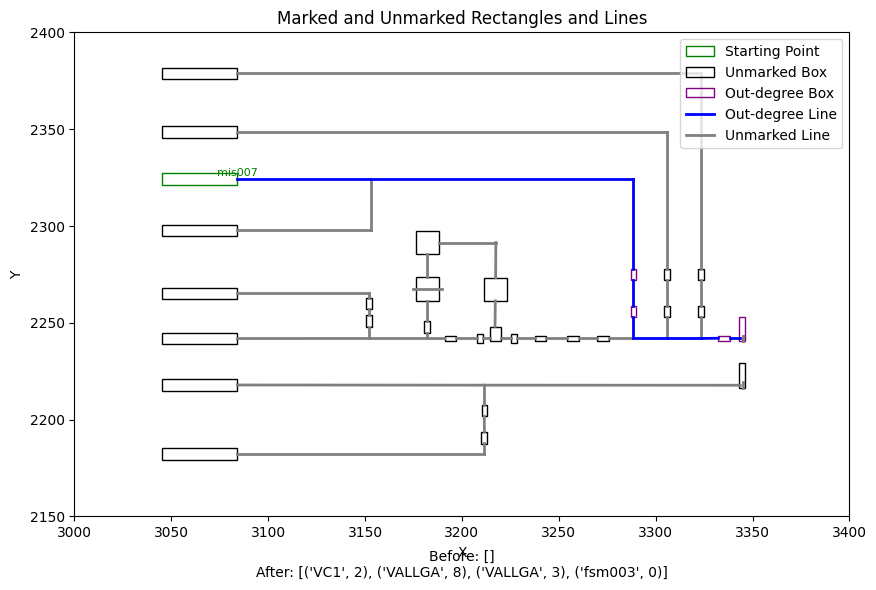

1
{('VC1', 0): [[8, 9]]}
[('mis007', 1), ('VC1', 0)]
[]
[8, 9]
[('VC1', 0)]
kaishi
jieshu
[('mis007', 1), ('VC1', 0)]
[]
[8, 9]
kaishi
found_blocks {('mis007', 1): [[9, 8]], ('VALLGA', 0): [[10]]}
start_block ('VC1', 0)
block_name_id_relationship [('mis007', 1), ('VC1', 0), ('VALLGA', 0)]
before_path []
after_path [8, 9, 10]
values_after [('VALLGA', 0)]
kaishi
found_blocks {('VC1', 0): [[10]], ('mis007', 2): [[11, 38]], ('VALLGA', 1): [[11, 12, 37]], ('VALLGA', 4): [[11, 12, 13]]}
start_block ('VALLGA', 0)
block_name_id_relationship [('mis007', 1), ('VC1', 0), ('VALLGA', 0), ('VALLGA', 4), ('VALLGA', 1)]
before_path []
after_path [8, 9, 10, 11, 12, 37, 13]
values_after [('VALLGA', 4), ('VALLGA', 1)]
kaishi
found_blocks {('PIP2', 0): [[15]], ('VALLGA', 4): [[37, 13]], ('mis007', 2): [[37, 12, 38]], ('VALLGA', 0): [[37, 12, 11]]}
start_block ('VALLGA', 1)
block_name_id_relationship [('mis007', 1), ('VC1', 0), ('VALLGA', 0), ('VALLGA', 4), ('VALLGA', 1), ('PIP2', 0)]
before_path []
after_

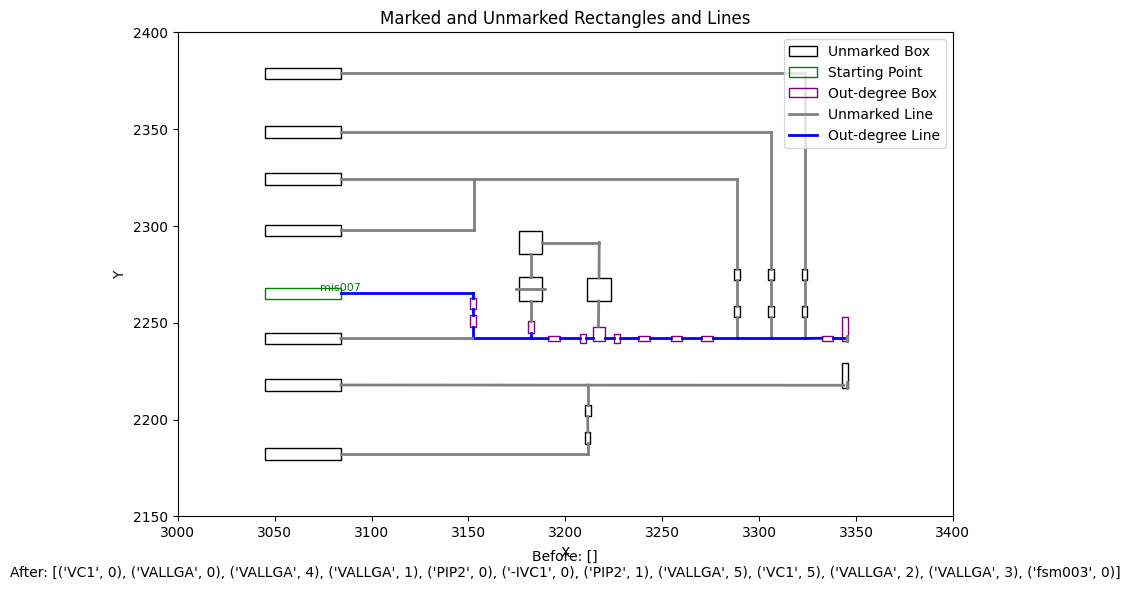

2
{('VALLGA', 1): [[38, 12, 37]], ('VALLGA', 4): [[38, 12, 13]], ('VALLGA', 0): [[38, 11]]}
[('mis007', 2), ('VALLGA', 4), ('VALLGA', 1)]
[]
[38, 12, 37, 13]
[('VALLGA', 4), ('VALLGA', 1)]
kaishi
jieshu
[('mis007', 2), ('VALLGA', 4), ('VALLGA', 1)]
[]
[38, 12, 37, 13]
kaishi
found_blocks {('PIP2', 0): [[15]], ('VALLGA', 4): [[37, 13]], ('mis007', 2): [[37, 12, 38]], ('VALLGA', 0): [[37, 12, 11]]}
start_block ('VALLGA', 1)
block_name_id_relationship [('mis007', 2), ('VALLGA', 4), ('VALLGA', 1), ('PIP2', 0)]
before_path []
after_path [38, 12, 37, 13, 15]
values_after [('PIP2', 0)]
kaishi
found_blocks {('VALLGA', 1): [[15]], ('-IVC1', 0): [[16]]}
start_block ('PIP2', 0)
block_name_id_relationship [('mis007', 2), ('VALLGA', 4), ('VALLGA', 1), ('PIP2', 0), ('-IVC1', 0)]
before_path []
after_path [38, 12, 37, 13, 15, 16]
values_after [('-IVC1', 0)]
kaishi
found_blocks {('PIP2', 0): [[16]], ('PIP2', 1): [[17]], ('INS01B', 1): [[39]]}
start_block ('-IVC1', 0)
block_name_id_relationship [('mis0

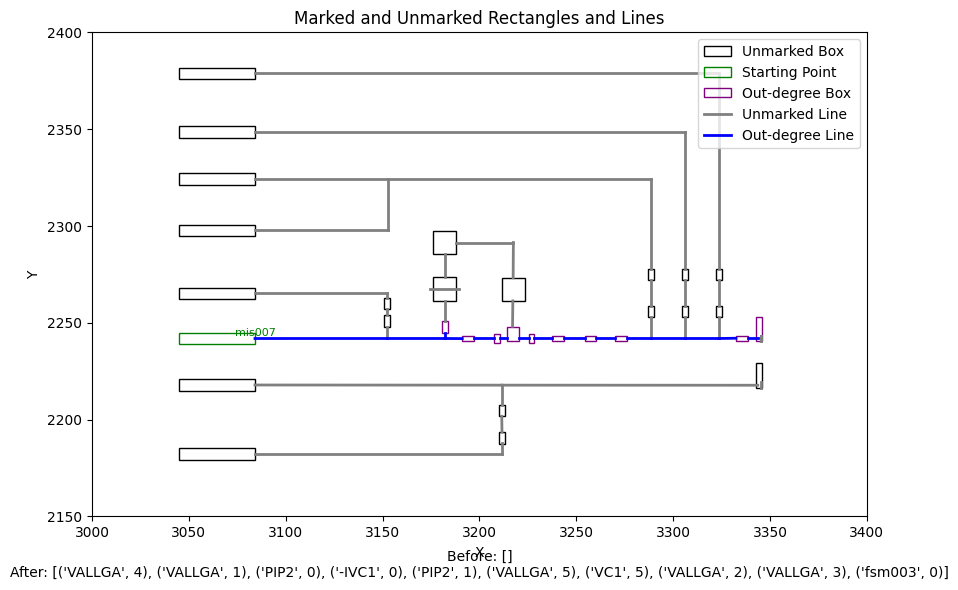

3
{('fsm003', 1): [[24, 41]], ('VALLGA', 9): [[24, 4]]}
[('mis007', 3), ('VALLGA', 9), ('fsm003', 1)]
[]
[24, 41, 4]
[('VALLGA', 9), ('fsm003', 1)]
kaishi
jieshu
[('mis007', 3), ('VALLGA', 9), ('fsm003', 1)]
[]
[24, 41, 4]
kaishi
found_blocks {('mis007', 3): [[41, 24]], ('VALLGA', 9): [[41, 4]]}
start_block ('fsm003', 1)
block_name_id_relationship [('mis007', 3), ('VALLGA', 9), ('fsm003', 1)]
before_path []
after_path [24, 41, 4]
values_after []
kaishi
jieshu
[('mis007', 3), ('VALLGA', 9), ('fsm003', 1)]
[]
[24, 41, 4]


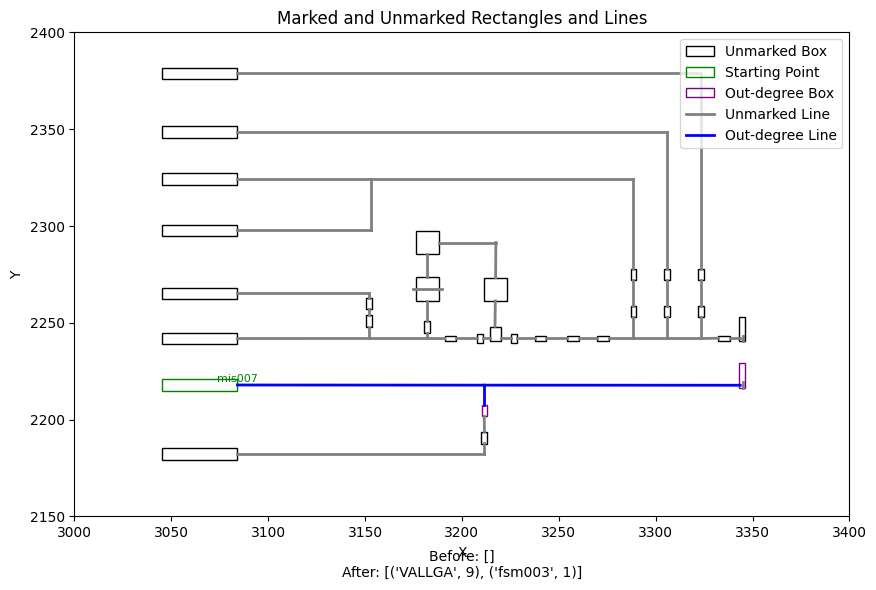

4
{('VC1', 1): [[5, 6]]}
[('mis007', 4), ('VC1', 1)]
[]
[5, 6]
[('VC1', 1)]
kaishi
jieshu
[('mis007', 4), ('VC1', 1)]
[]
[5, 6]
kaishi
found_blocks {('mis007', 4): [[6, 5]], ('VALLGA', 9): [[40]]}
start_block ('VC1', 1)
block_name_id_relationship [('mis007', 4), ('VC1', 1), ('VALLGA', 9)]
before_path []
after_path [5, 6, 40]
values_after [('VALLGA', 9)]
kaishi
found_blocks {('fsm003', 1): [[4, 41]], ('mis007', 3): [[4, 24]], ('VC1', 1): [[40]]}
start_block ('VALLGA', 9)
block_name_id_relationship [('mis007', 4), ('VC1', 1), ('VALLGA', 9), ('fsm003', 1)]
before_path []
after_path [5, 6, 40, 4, 41]
values_after [('fsm003', 1)]
kaishi
found_blocks {('mis007', 3): [[41, 24]], ('VALLGA', 9): [[41, 4]]}
start_block ('fsm003', 1)
block_name_id_relationship [('mis007', 4), ('VC1', 1), ('VALLGA', 9), ('fsm003', 1)]
before_path []
after_path [5, 6, 40, 4, 41]
values_after []
kaishi
jieshu
[('mis007', 4), ('VC1', 1), ('VALLGA', 9), ('fsm003', 1)]
[]
[5, 6, 40, 4, 41]


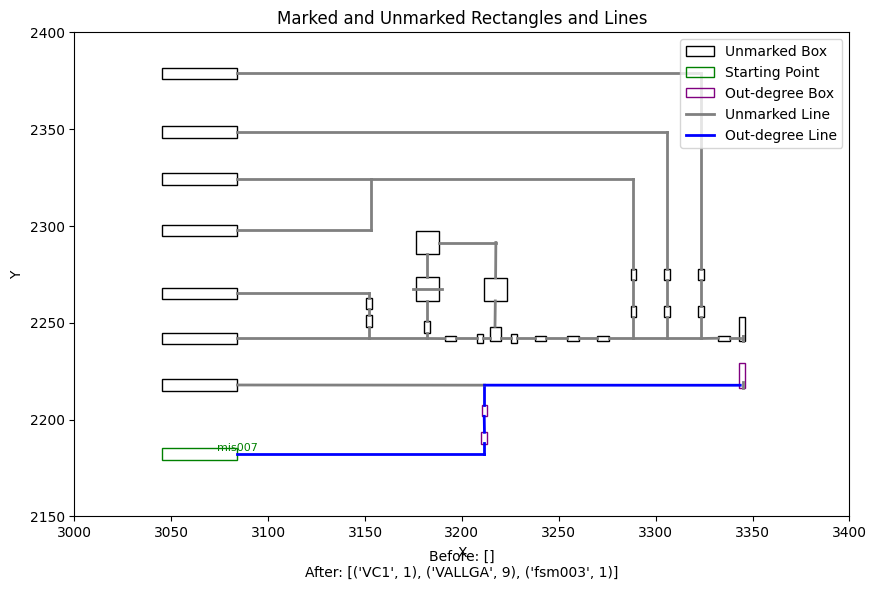

5
{('mis007', 0): [[26, 25, 42]], ('VC1', 2): [[26, 25, 3, 2]]}
[('mis007', 5), ('VC1', 2)]
[]
[26, 25, 3, 2]
[('VC1', 2)]
kaishi
jieshu
[('mis007', 5), ('VC1', 2)]
[]
[26, 25, 3, 2]
kaishi
found_blocks {('VALLGA', 8): [[1]], ('mis007', 0): [[2, 3, 42]], ('mis007', 5): [[2, 3, 25, 26]]}
start_block ('VC1', 2)
block_name_id_relationship [('mis007', 5), ('VC1', 2), ('VALLGA', 8)]
before_path []
after_path [26, 25, 3, 2, 1]
values_after [('VALLGA', 8)]
kaishi
found_blocks {('VALLGA', 3): [[0, 43, 44, 45]], ('VALLGA', 6): [[0, 43, 44, 31]], ('VALLGA', 7): [[0, 43, 34]], ('VALLGA', 2): [[0, 14]], ('VC1', 2): [[1]]}
start_block ('VALLGA', 8)
block_name_id_relationship [('mis007', 5), ('VC1', 2), ('VALLGA', 8), ('VALLGA', 3)]
before_path []
after_path [26, 25, 3, 2, 1, 0, 43, 44, 45]
values_after [('VALLGA', 3)]
kaishi
found_blocks {('fsm003', 0): [[7]], ('VALLGA', 7): [[45, 44, 34]], ('VALLGA', 2): [[45, 44, 43, 14]], ('VALLGA', 8): [[45, 44, 43, 0]], ('VALLGA', 6): [[45, 31]]}
start_block (

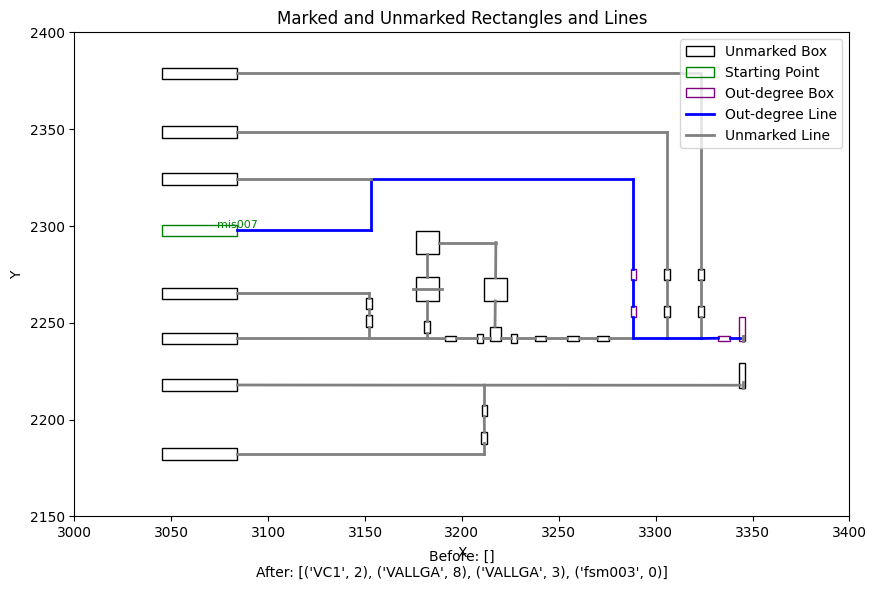

6
{('VC1', 3): [[27, 32]]}
[('mis007', 6), ('VC1', 3)]
[]
[27, 32]
[('VC1', 3)]
kaishi
jieshu
[('mis007', 6), ('VC1', 3)]
[]
[27, 32]
kaishi
found_blocks {('mis007', 6): [[32, 27]], ('VALLGA', 7): [[33]]}
start_block ('VC1', 3)
block_name_id_relationship [('mis007', 6), ('VC1', 3), ('VALLGA', 7)]
before_path []
after_path [27, 32, 33]
values_after [('VALLGA', 7)]
kaishi
found_blocks {('VC1', 3): [[33]], ('VALLGA', 3): [[34, 44, 45]], ('VALLGA', 6): [[34, 44, 31]], ('VALLGA', 2): [[34, 43, 14]], ('VALLGA', 8): [[34, 43, 0]]}
start_block ('VALLGA', 7)
block_name_id_relationship [('mis007', 6), ('VC1', 3), ('VALLGA', 7), ('VALLGA', 3)]
before_path []
after_path [27, 32, 33, 34, 44, 45]
values_after [('VALLGA', 3)]
kaishi
found_blocks {('fsm003', 0): [[7]], ('VALLGA', 7): [[45, 44, 34]], ('VALLGA', 2): [[45, 44, 43, 14]], ('VALLGA', 8): [[45, 44, 43, 0]], ('VALLGA', 6): [[45, 31]]}
start_block ('VALLGA', 3)
block_name_id_relationship [('mis007', 6), ('VC1', 3), ('VALLGA', 7), ('VALLGA', 3)

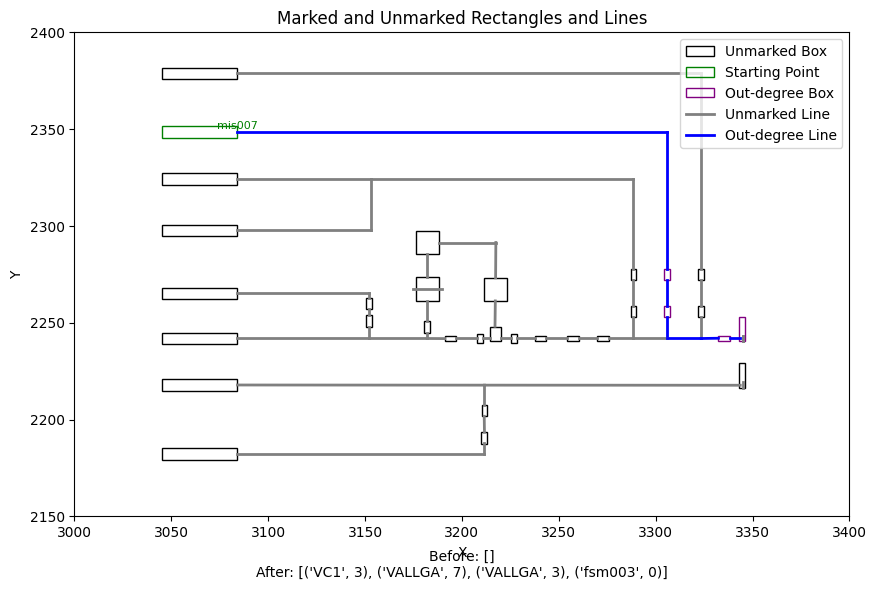

7
{('VC1', 4): [[28, 29]]}
[('mis007', 7), ('VC1', 4)]
[]
[28, 29]
[('VC1', 4)]
kaishi
jieshu
[('mis007', 7), ('VC1', 4)]
[]
[28, 29]
kaishi
found_blocks {('mis007', 7): [[29, 28]], ('VALLGA', 6): [[30]]}
start_block ('VC1', 4)
block_name_id_relationship [('mis007', 7), ('VC1', 4), ('VALLGA', 6)]
before_path []
after_path [28, 29, 30]
values_after [('VALLGA', 6)]
kaishi
found_blocks {('VC1', 4): [[30]], ('VALLGA', 3): [[31, 45]], ('VALLGA', 7): [[31, 44, 34]], ('VALLGA', 2): [[31, 44, 43, 14]], ('VALLGA', 8): [[31, 44, 43, 0]]}
start_block ('VALLGA', 6)
block_name_id_relationship [('mis007', 7), ('VC1', 4), ('VALLGA', 6), ('VALLGA', 3)]
before_path []
after_path [28, 29, 30, 31, 45]
values_after [('VALLGA', 3)]
kaishi
found_blocks {('fsm003', 0): [[7]], ('VALLGA', 7): [[45, 44, 34]], ('VALLGA', 2): [[45, 44, 43, 14]], ('VALLGA', 8): [[45, 44, 43, 0]], ('VALLGA', 6): [[45, 31]]}
start_block ('VALLGA', 3)
block_name_id_relationship [('mis007', 7), ('VC1', 4), ('VALLGA', 6), ('VALLGA', 3)

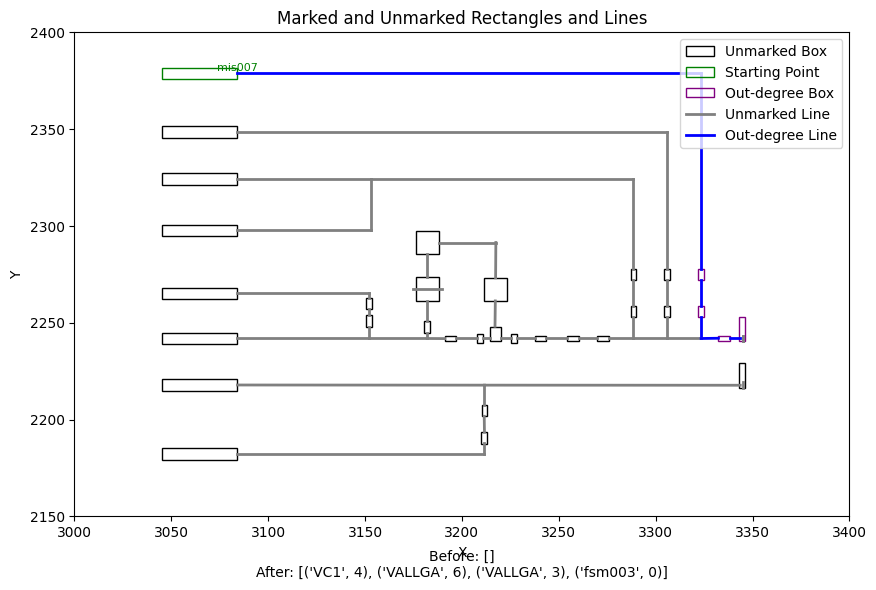

In [180]:
import ezdxf
from collections import Counter
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point, LineString
import numpy as np
from Entity import *
from shapely.geometry import LineString, box, Point
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import LineString
import copy
class DXFVisualizer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.doc = ezdxf.readfile(file_path)
        self.msp = self.doc.modelspace()

        # 初始化数据存储
        self.lines = []
        self.insert_points_aa2 = []
        self.insert_points_other = []
        self.intersections = {}
        self.insert_point_closest_line = {}  # 存储 AA2 插入点与最接近的线段的关系

    def read_lines(self):
        """读取所有 LINE 实体并存储"""
        colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'brown', 'pink', 'cyan', 'magenta']  # 预定义颜色
        for idx, entity in enumerate(self.msp.query('LINE')):
            start = (entity.dxf.start.x, entity.dxf.start.y)
            end = (entity.dxf.end.x, entity.dxf.end.y)
            # 为每条线段分配不同的颜色
            color = colors[idx % len(colors)]
            self.lines.append({"id": idx, "geometry": LineString([start, end]), "color": color})
        # 处理所有的 LWPOLYLINE 实体
        last_line_id = len(self.msp.query('LINE'))  # 获取最后一个 LINE 的 ID
        # 处理所有的 LWPOLYLINE 实体
        for idx, entity in enumerate(self.msp.query('LWPOLYLINE')):
            points = [(point[0], point[1]) for point in entity.vertices()]  # 修改这里，点是元组而非对象
            # 为每个多段线的线段分配不同的颜色
            color = colors[(idx + last_line_id) % len(colors)]  # 确保颜色不会重复
            for i in range(1, len(points)):
                start = points[i - 1]
                end = points[i]
                polyline_id = last_line_id + idx  # 设置 LWPOLYLINE 的 ID 为最后一个 LINE ID + 当前索引
                self.lines.append({"id": polyline_id, "geometry": LineString([start, end]), "color": color})
        
        
        return self.lines

    def find_intersections(self):
        """查找线段之间的交点"""
        intersections = {line["id"]: [] for line in self.lines}
        for i, line1 in enumerate(self.lines):
            for j, line2 in enumerate(self.lines):
                if i >= j:
                    continue  # 避免重复计算和自交点

                if line1["geometry"].intersects(line2["geometry"]):
                    point = line1["geometry"].intersection(line2["geometry"])
                    if not point.is_empty and point.geom_type == 'Point':
                        intersections[line1["id"]].append({"line_id": line2["id"], "point": (point.x, point.y)})
                        intersections[line2["id"]].append({"line_id": line1["id"], "point": (point.x, point.y)})

        self.intersections = intersections
        return self.intersections

    def read_inserts(self):
        """读取所有 INSERT 实体的插入点，并提取旋转角度"""
        for entity in self.msp:
            if entity.dxftype() == "INSERT":
                insert_point = entity.dxf.insert
                if entity.dxf.name == "AA2" or entity.dxf.name == "AA3" :
                    # 获取旋转角度，如果不存在则设为0
                    rotation_angle = getattr(entity.dxf, 'rotation', 0)  # 如果没有旋转角度，默认设为0
                    self.insert_points_aa2.append((insert_point.x, insert_point.y, rotation_angle,entity.dxf.name))
                else:
                    rotation_angle = getattr(entity.dxf, 'rotation', 0)  # 如果没有旋转角度，默认设为0
                    self.insert_points_other.append((insert_point.x, insert_point.y, rotation_angle,entity.dxf.name))
        return self.insert_points_aa2, self.insert_points_other

    @staticmethod
    def line_angle_with_axis(start, end, axis='x'):
        """计算线段与指定轴（x轴或y轴）的夹角"""
        dx = end[0] - start[0]  # 使用索引访问元组元素
        dy = end[1] - start[1]  # 使用索引访问元组元素
        if axis == 'x':
            return math.degrees(math.atan2(dy, dx))
        elif axis == 'y':
            return math.degrees(math.atan2(dx, dy))


    def find_closest_line_for_inserts(self):
        """查找每个 AA2 插入点最接近的线段（支持多个线段）"""
        for idx, point in enumerate(self.insert_points_aa2):
            point_geom = Point(point[0], point[1])
            rotation_angle = point[2]  # 获取旋转角度
            min_distance = float('inf')  # 初始化为一个很大的值
            closest_line_ids = []  # 存储所有最接近的线段 ID
            is_point_on_line = False  # 是否在线段上
    
            # 遍历所有线段，找到距离插入点最近的线段
            for line in self.lines:
                distance = point_geom.distance(line["geometry"])
                if distance < min_distance:
                    min_distance = distance
                    closest_line_ids = [line["id"]]  # 更新最接近的线段 ID 列表
                    # 检查点是否在线段上
                    if distance == 0:
                        is_point_on_line = True
                elif distance == min_distance:
                    closest_line_ids.append(line["id"])  # 如果距离相同，添加到结果列表
    
            # 确定与插入点旋转角度接近的方向
            filtered_line_ids = self.filter_lines_by_rotation(closest_line_ids, rotation_angle)
    
            # # 如果找到了符合条件的线段，使用它们
            # if filtered_line_ids:
            #     print(f"插入点 {point} 最接近的线段（根据旋转角度和夹角筛选）: {filtered_line_ids}")
            # else:
            #     print(f"插入点 {point} 找不到符合条件的线段")
    
            # 将筛选后的最接近的线段的 ID 和旋转角度一起记录
            self.insert_point_closest_line[idx] = {
                "line_ids": filtered_line_ids,  # 如果有多个最近的线段，存储所有的线段 ID
                "rotation_angle": rotation_angle,
                "is_point_on_line": is_point_on_line
            }
    
        return self.insert_point_closest_line

    def filter_lines_by_rotation(self, closest_line_ids, rotation_angle):
        """根据旋转角度过滤与坐标轴夹角小于10°的线段"""
        filtered_line_ids = []
        if rotation_angle % 360 < 10 or 170 < rotation_angle % 360 < 190:  # 旋转角度接近 0 或 180
            # 过滤与 x 轴夹角小于 10°的线段
            for line_id in closest_line_ids:
                line = self.lines[line_id]  # 获取线段
                angle = self.line_angle_with_axis(line["geometry"].coords[0], line["geometry"].coords[1], axis='x')
                if abs(angle) < 10 or abs(abs(angle) - 180) < 10:
                    filtered_line_ids.append(line_id)
        elif 80 < rotation_angle % 360 < 100 or 260 < rotation_angle % 360 < 280:  # 旋转角度接近 90 或 270
            # 过滤与 y 轴夹角小于 10°的线段
            for line_id in closest_line_ids:
                line = self.lines[line_id]  # 获取线段
                angle = self.line_angle_with_axis(line["geometry"].coords[0], line["geometry"].coords[1], axis='y')
                if abs(angle) < 10 or abs(abs(angle) - 180) < 10:
                    filtered_line_ids.append(line_id)

        return filtered_line_ids

    def build_line_info_dict(self):
        """通过 Insert Points AA2 Closest Line IDs with Rotation Angles 构建一个新的字典，
           键是 line_id，值是相关信息（如旋转角度、插入点信息等）
        """
        line_info_dict = {}
    
        # 遍历插入点与线段的关系
        for insert_idx, insert_info in self.insert_point_closest_line.items():
            rotation_angle = insert_info["rotation_angle"]
            is_point_on_line = insert_info["is_point_on_line"]
    
            # 遍历每个插入点关联的所有线段
            for line_id in insert_info["line_ids"]:
                if line_id not in line_info_dict:
                    line_info_dict[line_id] = {
                        "rotation_angles": [],  # 存储所有相关的旋转角度
                        "insert_points": [],    # 存储所有相关的插入点坐标
                        "is_point_on_line": is_point_on_line  # 插入点是否在线段上
                    }
    
                # 将该插入点的旋转角度添加到相应的线段信息中
                line_info_dict[line_id]["rotation_angles"].append(rotation_angle)
                line_info_dict[line_id]["insert_points"].append(self.insert_points_aa2[insert_idx])  # 使用插入点的坐标

        return line_info_dict

def find_connected_block_by_line(line_id, visited_lines=None, start_block_name=None, start_block_id=None, block_paths=None):
    if visited_lines is None:
        visited_lines = set()  # 使用 set 来避免重复访问
    if block_paths is None:
        block_paths = {}  # 用于存储块和路径的映射
    visited_lines = set()
    # 使用栈来模拟递归
    stack = [(line_id, [], visited_lines)]  # stack 存储 (当前line_id, 当前路径, 已访问的线段)
    while stack:
        current_line_id, path, visited_lines = stack.pop()
        # print("c:",current_line_id, "p:",path, "v:",visited_lines)
        path = path + [current_line_id]  # 更新当前路径

        # 如果该 line_id 已经访问过，跳过
        if current_line_id in visited_lines:
            continue

        # 标记当前 line_id 为已访问
        visited_lines.add(current_line_id)

        # 查找与当前 line_id 相关联的块
        connected_block = find_block_by_line_id(current_line_id)
        # 如果找到了一个连接的块，并且它不是起始块
        if connected_block:
            for b in connected_block:
                if connected_block and (b[0] != start_block_name or b[1] != start_block_id):
                    if b not in block_paths:
                        block_paths[b] = []  # 初始化该块的路径列表
                    block_paths[b].append(path)  # 记录路径
                    continue  # 找到目标块，跳过继续递归

        # 查找与当前 line_id 相交的所有线段
        intersecting_lines = intersections.get(current_line_id, [])
        # print("intersecting_lines",intersecting_lines)

        # 将所有与当前线段相交的线段压入栈中
        for intersection in intersecting_lines:
            intersected_line_id = intersection['line_id']
            if intersected_line_id not in visited_lines:
                stack.append((intersected_line_id, path, visited_lines.copy()))  # 使用路径副本，避免影响其他路径

    # 返回最终的块路径和已访问的线段
    return block_paths, visited_lines


def find_block_by_line_id(line_id):
    blocks = []  # 用于存储所有匹配的块信息
    for item in total_intersected_lines:
        if item['line_id'] == line_id:
            blocks.append((item['block_name'], item['block_id']))  # 将匹配的块添加到列表
    return blocks if blocks else None  # 如果找到匹配项，返回所有匹配的块；否则返回 None



# 查找给定 block_name 和 block_id 的所有相关线段
def find_line_ids_by_block(block_name, block_id):
    line_ids = []
    for item in total_intersected_lines:
        if item['block_name'] == block_name and item['block_id'] == block_id:
            line_ids.append(item['line_id'])
    return line_ids


def insert_before(a, target, value):
    # 查找目标值的位置
    index = a.index(target)
    # 插入新值，目标值的前面是目标值位置的索引
    a.insert(index, value)

def insert_after(a, target, value):
    # 查找目标值的位置
    index = a.index(target)
    # 插入新值，目标值位置后面是目标值位置+1
    a.insert(index + 1, value)

def check_order(a, b):
    # 假设 b 中包含 a 中的两个数字
    if len(b) != 2:
        return "error"  # 如果 b 不是两个数字，返回错误

    # 查找 a 中两个数字的索引
    first_index = a.index(b[0])
    second_index = a.index(b[1])

    # 判断两个数字是否相邻
    if abs(first_index - second_index) == 1:
        if first_index < second_index:
            return 1  # first_index 在 second_index 前
        else:
            return 0  # first_index 在 second_index 后
    else:
        return "error"  # 如果两个数字不相邻，则返回无法判断


def remove_key_by_value(d, value_to_remove):
    # 创建一个列表存储要删除的键
    keys_to_delete = [key for key, value in d.items() if value == value_to_remove]
    
    # 删除匹配的键
    for key in keys_to_delete:
        del d[key]
    
    return d

def get_rotation_for_line_ids(line_ids, insert_point_closest_line):
    rotations = {}
    # 遍历 insert_point_closest_line 中的所有记录
    for key, value in insert_point_closest_line.items():
        # 遍历每个 line_ids 列表中的元素
        for id in value['line_ids']:
            if id in line_ids:
                rotations[id] = value['rotation_angle']
    return rotations

def check_dicts_in_list(dict_list):
    if all(d == dict_list[0] for d in dict_list):
        return dict_list[0]
    else:
        return "error"

def get_line_info_by_id(lines, line_id):
    """
    根据线的id从lines中提取对应的信息
    :param lines: 包含线信息的列表
    :param line_id: 要提取的线id
    :return: 提取的线信息，或None
    """
    for line in lines:
        if line['id'] == line_id:
            geometry = line['geometry']
            # 如果geometry是LineString对象，可以直接获取坐标
            if isinstance(geometry, LineString):
                return {
                    'geometry': geometry,
                    'color': line['color']
                }
            else:
                # 如果geometry是字符串，需要转换为LineString对象
                geometry_coords = parse_geometry(geometry)
                return {
                    'geometry': LineString(geometry_coords),
                    'color': line['color']
                }
    return None


def determine_direction(lines, id1, id2, arrow_direction, arrow_on_line_id):
    """
    判断两条线的指向关系，考虑箭头在哪条线上
    :param lines: 包含线信息的列表
    :param id1: 第一条线的id
    :param id2: 第二条线的id
    :param arrow_direction: 箭头方向 ("left", "right", "up", "bottom")
    :param arrow_on_line_id: 箭头在哪条线上（"id1" 或 "id2"）
    :return: 指向关系数据结构，便于后续处理
    """
    line1_info = get_line_info_by_id(lines, id1)
    line2_info = get_line_info_by_id(lines, id2)

    if line1_info is None or line2_info is None:
        return {"error": f"未找到id为{id1}或{id2}的线段"}

    line1 = line1_info['geometry']
    line2 = line2_info['geometry']

    # 获取交点
    intersection = line1.intersection(line2)
    if intersection.is_empty:
        return {"error": "两条线不相交"}

    # 获取交点的坐标
    intersection_point = (intersection.x, intersection.y)

    # 获取箭头所在线段的起点和终点
    if arrow_on_line_id == id1:
        start_point, end_point = get_arrow_endpoints(line1, arrow_direction)
        # print(start_point, end_point)
    elif arrow_on_line_id == id2:
        start_point, end_point = get_arrow_endpoints(line2, arrow_direction)
    else:
        return {"error": "无效的箭头所在线段ID"}
    # print( intersection.x , start_point[0])
    # 判断箭头方向和交点相对起点的位置
    is_towards_arrow = False
    if arrow_direction == "left":
        is_towards_arrow = intersection.x < start_point[0]
    elif arrow_direction == "right":
        is_towards_arrow = intersection.x > start_point[0]
    elif arrow_direction == "up":
        is_towards_arrow = intersection.y > start_point[1]
    elif arrow_direction == "bottom":
        is_towards_arrow = intersection.y < start_point[1]
    else:
        return {"error": "无效的箭头方向"}

    # 基于箭头方向和交点位置来决定流动方向
    if is_towards_arrow:
        # 如果一致，流动方向是由基准线段指向另一条线段
        flow_info = {
            "flow_direction": f"从线{id1}到线{id2}" if arrow_on_line_id == id1 else f"从线{id2}到线{id1}",
            "from_line_id": id1 if arrow_on_line_id == id1 else id2,
            "to_line_id": id2 if arrow_on_line_id == id1 else id1
        }
    else:
        # 否则，流动方向是由另一条线段指向基准线段
        flow_info = {
            "flow_direction": f"从线{id2}到线{id1}" if arrow_on_line_id == id1 else f"从线{id1}到线{id2}",
            "from_line_id": id2 if arrow_on_line_id == id1 else id1,
            "to_line_id": id1 if arrow_on_line_id == id1 else id2
        }
    return flow_info

def get_arrow_endpoints(line, arrow_direction):
    """
    根据箭头方向来获取线段的起点和终点
    :param line: 线段
    :param arrow_direction: 箭头方向
    :return: 起点和终点
    """
    start_point, end_point = line.coords[0], line.coords[-1]
    
    if arrow_direction == "left":
        # 起点在右，终点在左
        if start_point[0] < end_point[0]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "right":
        # 起点在左，终点在右
        if start_point[0] > end_point[0]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "up":
        # 起点在下，终点在上
        if start_point[1] > end_point[1]:
            start_point, end_point = end_point, start_point
    elif arrow_direction == "bottom":
        # 起点在上，终点在下
        if start_point[1] < end_point[1]:
            start_point, end_point = end_point, start_point

    return start_point, end_point

def get_arrow_direction_by_rotation(dic):
    """
    根据旋转角度确定箭头的方向
    :param rotation_angle: 旋转角度
    :return: 箭头方向 ("right", "up", "left", "bottom")
    """
    for id,rotation_angle in dic.items():
    
        if abs(rotation_angle) < 45 or abs(rotation_angle) > 315:
            dic[id]="right"
        elif 45 <= abs(rotation_angle) < 135:
            dic[id]= "up"
        elif 135 <= abs(rotation_angle) < 225:
            dic[id]= "left"
        elif 225 <= abs(rotation_angle) < 315:
            dic[id]= "bottom"
    return dic  # 默认情况

def two_lines_direction(liness,insert_point_closest_line):
        rotations = get_rotation_for_line_ids(liness, insert_point_closest_line)
        line_id_direction=get_arrow_direction_by_rotation(rotations)
        line_id1 = liness[0]
        line_id2 = liness[1]
        result_list = []
        for index, j in enumerate(line_id_direction.values()):
            arrow_on_line_id = list(line_id_direction.keys())[index]
            arrow_direction = j
            # print("arrow_direction, arrow_on_line_id:",arrow_direction, arrow_on_line_id)
            result = determine_direction(lines, line_id1, line_id2, arrow_direction, arrow_on_line_id)
            result_list.append(result)
            result = check_dicts_in_list(result_list)
        return result

def find_direction(start, end, direction, rectangles_info):
    # 查找给定name和id的矩形信息
    def get_rectangle_info(name, id):
        for rect in rectangles_info:
            if rect['name'] == name and rect['id'] == id:
                return rect['bounding_box']
        return None

    start_name, start_id = start
    end_name, end_id = end
    
    # 获取起始矩形和目标矩形的bounding_box
    start_bbox = get_rectangle_info(start_name, start_id)
    end_bbox = get_rectangle_info(end_name, end_id)
    
    if not start_bbox or not end_bbox:
        return "Invalid input: start or end block not found."
    
    # 解析bounding_box
    x1_start, y1_start, x2_start, y2_start = start_bbox
    x1_end, y1_end, x2_end, y2_end = end_bbox

    # 根据方向判断是否符合流向条件
    if direction == 'right':
        # 判断第一个block的右边界小于第二个block的左边界
        if x2_start < x1_end:
            return 1
        else:
            return 0
    
    elif direction == 'left':
        # 判断第一个block的左边界大于第二个block的右边界
        if x1_start > x2_end:
            return 1
        else:
            return 0
    
    elif direction == 'up':
        # 判断第一个block的上边界大于第二个block的下边界
        if y1_start < y2_end:
            return 1
        else:
            return 0
    
    elif direction == 'bottom':
        # 判断第一个block的下边界小于第二个block的上边界
        if y2_start > y1_end:
            return 1
        else:
            return 0
    
    else:
        return "Invalid direction input."

# 示例调用：
def block_to_path_to_block(block_name,block_id,total_intersected_lines):

    # 查找与 block_name 和 block_id 相关的所有 line_id
    initial_line_ids = find_line_ids_by_block(block_name, block_id)
    
    if not initial_line_ids:
        print(f"No lines found for block {block_name}, block_id {block_id}.")
    else:
        # 通过栈模拟递归查找与这些 line_id 相关联的块
        found_blocks = {}  # 存储每个找到的块和路径
        visited_lines = set()  # 使用 set 来记录已访问的 line_id
        for line_id in initial_line_ids:
            # 对于每个 line_id，查找是否与其他块连接
            connected_block_paths, visited_lines = find_connected_block_by_line(
                line_id, visited_lines, start_block_name=block_name, start_block_id=block_id, block_paths=found_blocks
            )
            
            if connected_block_paths:
                found_blocks = connected_block_paths  # 更新找到的块和路径
        
        if found_blocks:
            # for block, liness in found_blocks.items():
            #     print(f"Block: {block[0]} (ID: {block[1]})")
            #     for line in liness:
            #         print(f"  Passed line_ids: {line}")
            return found_blocks
        else:
            print(f"No connected block found for block_name '{block_name}' and block_id {block_id}.")
            print(f"Visited line_ids: {visited_lines}")
            return 0

def a(found_blocks,insert_point_closest_line,block_name_id_relationships,before_path,after_path,start_block,flow):
    block_name_id_relationships_copy = copy.deepcopy(block_name_id_relationships)
    for block,liness in found_blocks.items():
        # print(block)
        # print(liness[0])
        if len(liness[0]) == 1:
            rotations = get_rotation_for_line_ids(liness[0], insert_point_closest_line)
            # print(rotations)
            line_id_direction=get_arrow_direction_by_rotation(rotations)
            result = find_direction(start_block,block,list(line_id_direction.values())[0],rectangles_info)
            if flow == "both":
                # print(find_direction)
                if result:
                    insert_after(block_name_id_relationships_copy,start_block,block)
                    after_path.append(liness[0][0])
                else :
                    insert_before(block_name_id_relationships_copy,start_block,block)
                    before_path.append(liness[0][0])
            elif flow == "before":
                # print(find_direction)
                if result:
                    # insert_after(block_name_id_relationships_copy,start_block,block)
                    # after_path.append(liness[0][0])
                    pass
                else :
                    insert_before(block_name_id_relationships_copy,start_block,block)
                    before_path.append(liness[0][0])
            else :
                # print(find_direction)
                if result:
                    insert_after(block_name_id_relationships_copy,start_block,block)
                    after_path.append(liness[0][0])
                # else :
                #     insert_before(block_name_id_relationships_copy,start_block,block)
                #     before_path.append(liness[0][0])

        elif len(liness[0]) == 2:
            result_list = two_lines_direction(liness[0],insert_point_closest_line)
            if result_list == "error" :
               pass 
            else :
                # print(result_list)
                list1 = []
                list1.append(result_list['from_line_id'])
                list1.append(result_list['to_line_id'])
                result = check_order(liness[0], list1)
                if flow == "both":
                    if result:
                        insert_after(block_name_id_relationships_copy,start_block,block)
                        after_path.append(result_list['from_line_id'])
                        after_path.append(result_list['to_line_id'])
                    else :
                        insert_before(block_name_id_relationships_copy,start_block,block)
                        before_path.append(result_list['from_line_id'])
                        before_path.append(result_list['to_line_id'])
                elif flow == "before":
                    if result:
                        # insert_after(block_name_id_relationships_copy,start_block,block)
                        # after_path.append(result_list['from_line_id'])
                        # after_path.append(result_list['to_line_id'])
                        pass
                    else :
                        insert_before(block_name_id_relationships_copy,start_block,block)
                        before_path.append(result_list['from_line_id'])
                        before_path.append(result_list['to_line_id'])  
                else :
                    if result:
                        insert_after(block_name_id_relationships_copy,start_block,block)
                        after_path.append(result_list['from_line_id'])
                        after_path.append(result_list['to_line_id'])
                    # else :
                    #     insert_before(block_name_id_relationships_copy,start_block,block)
                    #     before_path.append(result_list['from_line_id'])
                    #     before_path.append(result_list['to_line_id'])
                # list2 = block_name_id_relationships_copy
                # return list2,before_path,after_path
        else:
            list1 = []
            for i in range(len(liness[0])-1):
                result_list = two_lines_direction(liness[0][i:i+2],insert_point_closest_line)
                if result_list == "error" :
                    break
                if i == 0 :
                    list1.append(result_list['from_line_id'])
                    list1.append(result_list['to_line_id'])

            if result_list != "error":
                result = check_order(liness[0], list1)
                # print("liness[0]:",liness[0],"list1:",list1,result)
                if flow == "both":
                    if result:
                            insert_after(block_name_id_relationships_copy,start_block,block)
                            after_path.extend(liness[0])
                    else :
                            insert_before(block_name_id_relationships_copy,start_block,block)
                            before_path.extend(liness[0])
                elif flow == "before":
                    if result:
                            # insert_after(block_name_id_relationships_copy,start_block,block)
                            # after_path.extend(liness[0])
                        pass
                    else :
                            insert_before(block_name_id_relationships_copy,start_block,block)
                            before_path.extend(liness[0])
                else :
                    if result:
                            insert_after(block_name_id_relationships_copy,start_block,block)
                            after_path.extend(liness[0])
                    # else :
                    #         insert_before(block_name_id_relationships_copy,start_block,block)
                    #         before_path.extend(liness[0])
                # list2 = block_name_id_relationships_copy
    return list(dict.fromkeys(block_name_id_relationships_copy)),list(dict.fromkeys(before_path)),list(dict.fromkeys(after_path))

def process_block_after(values_after, block_name_id_relationship, max_iterations, iteration_count=0, flow="after", before_path=None, after_path=None):
    print("kaishi")
    
    # 如果 values_before 为空或达到最大迭代次数，则停止递归
    if not values_after or iteration_count >= max_iterations:
        if iteration_count >= max_iterations:
            print("Reached max iterations, terminating to avoid dead loop.")
        return  block_name_id_relationship, before_path, after_path

    # 递增迭代次数
    iteration_count += 1

    # 取出当前处理的块 (values_before 中的第一个块)
    for start_block in reversed(values_after):
    
        block_name = start_block[0]
        block_id = start_block[1]
        
        found_blocks = block_to_path_to_block(block_name,block_id,total_intersected_lines)
        # 对每个键，保留长度最短的值
        for key in found_blocks:
            # 对每个键的列表进行排序，选择最短的列表
            found_blocks[key] = [min(found_blocks[key], key=len)]
        if found_blocks:  # 确保 found_blocks 非空
            print("found_blocks",found_blocks)
            block_name_id_relationship, before_path, after_path = a(
                found_blocks, insert_point_closest_line, block_name_id_relationship, before_path, after_path, start_block, flow
            )
            
            print("start_block", start_block)
            print("block_name_id_relationship", block_name_id_relationship)
            print("before_path", before_path)
            print("after_path", after_path)

            # 更新 values_before 以去掉当前处理的 start_block
            start_block_index = block_name_id_relationship.index(start_block)
            values_after = block_name_id_relationship[start_block_index+1:]
            
            print("values_after", values_after)

            # 递归调用 process_block 处理下一个块
            return process_block_after(values_after, block_name_id_relationship, max_iterations, iteration_count, flow, before_path, after_path)
            
def process_block_before(values_before, block_name_id_relationship, max_iterations, iteration_count=0, flow="before", before_path=None, after_path=None):
    print("kaishi")
    
    # 如果 values_before 为空或达到最大迭代次数，则停止递归
    if not values_before or iteration_count >= max_iterations:
        if iteration_count >= max_iterations:
            print("Reached max iterations, terminating to avoid dead loop.")
        return  block_name_id_relationship, before_path, after_path

    # 递增迭代次数
    iteration_count += 1

    # 取出当前处理的块 (values_before 中的第一个块)
    for start_block in reversed(values_before):
    
        block_name = start_block[0]
        block_id = start_block[1]
        
        found_blocks = block_to_path_to_block(block_name,block_id,total_intersected_lines)
        # 对每个键，保留长度最短的值
        for key in found_blocks:
            # 对每个键的列表进行排序，选择最短的列表
            found_blocks[key] = [min(found_blocks[key], key=len)]
        if found_blocks:  # 确保 found_blocks 非空
            print("found_blocks",found_blocks)
            block_name_id_relationship, before_path, after_path = a(
                found_blocks, insert_point_closest_line, block_name_id_relationship, before_path, after_path, start_block, flow
            )
            
            print("start_block", start_block)
            print("block_name_id_relationship", block_name_id_relationship)
            print("before_path", before_path)
            print("after_path", after_path)

            # 更新 values_before 以去掉当前处理的 start_block
            start_block_index = block_name_id_relationship.index(start_block)
            values_before = block_name_id_relationship[:start_block_index]
            
            print("values_before", values_before)

            # 递归调用 process_block 处理下一个块
            return process_block_before(values_before, block_name_id_relationship, max_iterations, iteration_count, flow, before_path, after_path)
    

def main(file_path,block_name_start):
     # 替换为你的 DXF 文件路径
    target_dxf = file_path
    # 创建对象
    visualizer = DXFVisualizer(file_path)
    
    # 获取线段数据
    global lines
    lines = visualizer.read_lines()
    # print("Lines:", lines)
    
    # 查找交点
    global intersections
    intersections = visualizer.find_intersections()
    # print("Intersections:", intersections)
    
    # 获取插入点数据
    insert_points_aa2, insert_points_other = visualizer.read_inserts()
    # print("Insert Points AA2:", insert_points_aa2)
    # print("Insert Points Other:", insert_points_other)
    
    # 查找每个 AA2 插入点最接近的直线
    global insert_point_closest_line
    insert_point_closest_line = visualizer.find_closest_line_for_inserts()
    # print("Insert Points AA2 Closest Line IDs with Rotation Angles:", insert_point_closest_line)
    
    # 构建线段信息字典
    line_info_dict = visualizer.build_line_info_dict()
    block_name = [i[-1] for i in insert_points_other] 
    block_name = list(set(block_name))
    global total_intersected_lines
    total_intersected_lines = []
    total_bounding_boxes = []
    for i in block_name:
    
        source_dxf = f"extracted_blocks/{i}.dxf"
        
        matching_results = find_matching_entities(source_dxf, target_dxf)
        
        # 打印找到的匹配实体数量
        # print(f"Found {len(matching_results)} matching entities for block '{i}'.")
    
        # 用来存储矩形框（Bounding Boxes）
        bounding_boxes = []
    
        # 遍历每个匹配结果
        for idx, result in enumerate(matching_results):
    
            result['bounding_box'] = (
                (result['bounding_box'][0][0] - 1, result['bounding_box'][0][1] - 1),
                (result['bounding_box'][1][0] + 1, result['bounding_box'][1][1] + 1)
            )
            # print(f"ID: {idx}, Result: {result}")
            # 从字典读取bounding_box坐标
            bounding_box = result['bounding_box']
            
            # 创建矩形框
            rect = box(bounding_box[0][0], bounding_box[0][1], bounding_box[1][0], bounding_box[1][1])
            
            # 添加到bounding_boxes列表
            bounding_boxes.append({'id': idx, 'rect': rect})
            total_bounding_boxes.append({'id': idx, 'rect': rect,"name":i})
            # 记录相交的线段和交点
            intersected_lines = []
            
            # 遍历每一条线段
            for line_data in lines:
                line = line_data['geometry']
                # 查找交点
                intersection = line.intersection(rect)
                
                if not intersection.is_empty:
                    if isinstance(intersection, Point):
                        # 交点是单个点，表示它与矩形框的某个边相交
                        position = 'on boundary'
                    elif isinstance(intersection, LineString):
                        # 如果交点是线段，说明这条线段穿过矩形框
                        position = 'crossing'
                    else:
                        position = 'outside'  # 其他情况认为是外部
            
                    # 添加信息
                    intersected_lines.append({
                        'line_id': line_data['id'],
                        'color': line_data['color'],
                        'intersection': intersection,
                        'position': position
                    })
                    total_intersected_lines.append({"block_id" : idx,
                        "block_name" : i ,
                        'line_id': line_data['id'],
                        'color': line_data['color'],
                        'intersection': intersection,
                        'position': position
                    })
    # 保存矩形框的信息
    global rectangles_info
    rectangles_info = []
    
    # 遍历每个块的名称
    for i in block_name:
        source_dxf = f"extracted_blocks/{i}.dxf"
        matching_results = find_matching_entities(source_dxf, target_dxf)
        
        # print(f"Found {len(matching_results)} matching entities for block '{i}'.")
    
        # 遍历每个匹配结果并记录矩形框信息
        for idx, result in enumerate(matching_results):
            # print(f"ID: {idx}, Result: {result}")
            
            # 从字典读取bounding_box坐标
            bounding_box = result['bounding_box']
            
            if len(bounding_box) != 2 or len(bounding_box[0]) != 2 or len(bounding_box[1]) != 2:
                print(f"Skipping invalid bounding box: {bounding_box}")
                continue  # 跳过无效的bounding_box
            
            # 从两个点计算 x_min, y_min, x_max, y_max
            (x_min, y_min), (x_max, y_max) = bounding_box
            
            # 创建矩形框并保存信息
            rect_info = {
                'id': idx,
                'name': i,
                'bounding_box': (x_min, y_min, x_max, y_max)
            }
            rectangles_info.append(rect_info)
    block_names = [point[3] for point in insert_points_other]
    block_count = Counter(block_names)
    print(block_count)
    print(block_name_start)
    block_name = block_name_start
    for block_id in range(block_count.get(block_name, 0)):
        print(block_id)
        # block_name = 'INS07_new'
        # block_id = 0
        flow = "both"
        
        # block_id = 2
        start_block=(block_name,block_id)
        block_name_id_relationship = [(block_name,block_id)]
        before_path =[]
        after_path = []
        found_blocks = block_to_path_to_block(block_name,block_id,total_intersected_lines)
        # 对每个键，保留长度最短的值
        for key in found_blocks:
            # 对每个键的列表进行排序，选择最短的列表
            found_blocks[key] = [min(found_blocks[key], key=len)]
        print(found_blocks)
        if found_blocks != 0 :
        # found_blocks
            block_name_id_relationship,before_path,after_path = a(found_blocks,insert_point_closest_line,block_name_id_relationship,before_path,after_path,start_block,flow)
            print(block_name_id_relationship)
            print(before_path)
            print(after_path)
        
        start_block_index = block_name_id_relationship.index(start_block)
        values_before = block_name_id_relationship[:start_block_index]
        values_after = block_name_id_relationship[start_block_index + 1:]
        # print(values_before)
        print(values_after)
        max_iterations = 10  # 设定最大迭代次数，防止死循环
        iteration_count = 0   
        block_name_id_relationship_b, before_path, after_path = process_block_before(values_before, block_name_id_relationship, max_iterations, iteration_count=0, flow="before", before_path=before_path, after_path=after_path)    
        print("jieshu")
        print(block_name_id_relationship_b)
        print(before_path)
        print(after_path)
        block_name_id_relationship_a, before_path, after_path = process_block_after(values_after, block_name_id_relationship, max_iterations, iteration_count=0, flow="after", before_path=before_path, after_path=after_path)    
        print("jieshu")
        print(block_name_id_relationship_a)
        print(before_path)
        print(after_path)
        
        start_index_b = block_name_id_relationship_b.index(start_block)
        start_index_a = block_name_id_relationship_a.index(start_block)
        block_name_id_relationship_before = block_name_id_relationship_b[:start_index_b]
        block_name_id_relationship_after = block_name_id_relationship_a[start_index_a + 1:]
        # 创建图形
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # 绘制矩形框（已标记的为红色，未标记的为黑色）
        for rect in rectangles_info:
            x, y = rect['bounding_box'][2], rect['bounding_box'][3]
            if (rect['name'], rect['id']) in block_name_id_relationship_before:
                # 已标记的矩形框为红色
                ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                               rect['bounding_box'][2] - rect['bounding_box'][0],
                                               rect['bounding_box'][3] - rect['bounding_box'][1],
                                               linewidth=1, edgecolor='red', facecolor='none', label='In-degree Box'))
            elif (rect['name'], rect['id']) in block_name_id_relationship_after:
                # 已标记的矩形框为紫色
                ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                               rect['bounding_box'][2] - rect['bounding_box'][0],
                                               rect['bounding_box'][3] - rect['bounding_box'][1],
                                               linewidth=1, edgecolor='purple', facecolor='none', label='Out-degree Box'))
            elif (rect['name'], rect['id']) == start_block:
                # 已标记的矩形框为绿色（出发点）
                ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                               rect['bounding_box'][2] - rect['bounding_box'][0],
                                               rect['bounding_box'][3] - rect['bounding_box'][1],
                                               linewidth=1, edgecolor='green', facecolor='none', label='Starting Point'))
                ax.text(x, y, f'{rect["name"]}', color='green', fontsize=8, ha='center', va='center')
            else:
                # 未标记的矩形框为黑色
                ax.add_patch(patches.Rectangle((rect['bounding_box'][0], rect['bounding_box'][1]),
                                               rect['bounding_box'][2] - rect['bounding_box'][0],
                                               rect['bounding_box'][3] - rect['bounding_box'][1],
                                               linewidth=1, edgecolor='black', facecolor='none', label='Unmarked Box'))
        
        # 绘制线段（已标记的为橙色，未标记的为灰色）
        for line in lines:
            if line['id'] in before_path:
                x, y = line['geometry'].xy
                ax.plot(x, y, color='orange', lw=2, label='In-degree Line')  # 已标记的线段为橙色
            elif line['id'] in after_path:
                x, y = line['geometry'].xy
                ax.plot(x, y, color='blue', lw=2, label='Out-degree Line')  # 已标记的线段为蓝色
            else:
                x, y = line['geometry'].xy
                ax.plot(x, y, color='gray', lw=2, label='Unmarked Line')  # 未标记的线段为灰色
        
        # 设置轴范围
        ax.set_xlim(3000, 3400)
        ax.set_ylim(2150, 2400)
        
        # 添加图例
        handles, labels = ax.get_legend_handles_labels()
        # 去除重复的标签（因为每次循环都会添加标签）
        unique_handles = []
        unique_labels = []
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                unique_labels.append(label)
                unique_handles.append(handle)
        
        ax.legend(unique_handles, unique_labels, loc='upper right')
        
        # 在图像底部添加 block_name_id_relationship_before 和 block_name_id_relationship_after 的内容
        bottom_text = f"Before: {block_name_id_relationship_before}\nAfter: {block_name_id_relationship_after}"
        plt.text(0.5, -0.1, bottom_text, ha='center', va='center', fontsize=10, transform=ax.transAxes)
        
        # 显示并保存图像
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Marked and Unmarked Rectangles and Lines')
        plt.savefig(f'in_out_{block_name}_{block_id}.png', bbox_inches='tight')
        plt.show()
if __name__ == "__main__":
    global insert_point_closest_line
    global intersections
    global lines 
    global total_intersected_lines
    global rectangles_info
    file_path = "./dxf/Drawing1.dxf" 
    block_name = 'INS07_new'
    main(file_path,block_name)